# The Second Part of the Assignment of IDS 2019-2020
Document your results as well as the way you obtained them in this jupyter notebook. Separate reports (pdf, word, etc.) are _not_ required. However, it is necessary that you provide the python code leading to your results as well as textual answers to the assignment questions in this notebook. *DO NOT CLEAR THE OUTPUT of the notebook you are submitting!* In the cases that the result of an algorithm is pdf, jpg, etc, you should attach the result to this notebook file and refer to that in the text.  

Next to the jupyter notebook, submit one zip-file containing all data sets that you are asked to submit. Make sure they are easily identifiable, i.e. use names as requested in the corresponding question.

Do not change the general structure of this notebook, but you can add further markdown or code cells to explain your solutions if necessary. In the end, submit this file and your created data sets in moodle.

Only <font color="red">one </font> group member should upload your group's solution.*Make sure to include group members' names and matriculation numbers*. If your name and student id are not included in the report, you will not receive any points!


Hint 1: While answering the questions, you will get a better and better impression of the given data. <font color="red"><b>Ensure that all claims you make are supported by the presented facts!</b></font>

Hint 2: <font color="red"><b>Some of the tasks might need some time to run. Take this into account in your planning.</b></font>

Hint 3: RWTHonline allows for multiple submissions (each submission overwrites the previous ones). <font color="red"><b>Partial submissions are possible and encouraged. </b></font> This helps in case of technical problems of RWTHonline, which do seldomly happen.

<font color="red"><b>Student Names and IDs:
    1. Mubashirul Islam Shaikh :391985
    2. Chrishanthi Priya Sivakumar : 391430
    3. Priyanka Mahadev Zalake : 391346
    

## Preprocessing of the Dataset (5 points)

The provided data set *air_pollution* contains hourly results of measuring the concentration of certain substances (CO, Benzene, NO2, particulate matter) and environmental conditions (temperature, relative humidity, traffic volume). This data was collected near a busy street in a city center by an automated device.

 You should carry out some preprocessing steps before starting the analysis:
 - Select 90% of 'air_pollution' dataset by random sampling. Use one of the group member's student number as a seed.
 - After completing this preprocessing step, export your final dataset as 'air_pollution_2.csv' dataset and use that for the next steps of the assignment.
 - If it is not directly mentioned, you should always use your extracted (above-created) dataset.
 - <font color='red'>Important!</font> Make sure that you submit your extracted dataset with your result in moodle.

In [22]:
# #Execute this code ONLY IF YOU HAVEN'T INSTALLED THE PACKAGES BEFORE
# #Uncomment them to Install
# !pip install gensim
# !pip install mlxtend
# !pip install stop_words
# !pip install pm4py

In [1]:
#Importing libraries
#It will take some time to import so be patient
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from pandas import DataFrame
import numpy as np
import pandas as pd
import csv
import math
import seaborn as sns
from pm4py.objects.log.importer.xes import factory as xes_import_factory
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.visualization.petrinet import factory as pn_vis_factory
from pm4py.algo.conformance.tokenreplay import factory as token_based_replay_factory
from pm4py.evaluation.replay_fitness import factory as replay_fitness_factory
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules as arule
import re
from nltk import FreqDist
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer, PorterStemmer
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metric
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk

In [3]:
q1 = pd.read_csv("Datasets/air_pollution.csv")
pd_sample1 = q1.sample(frac=0.9, replace=False, random_state=391985)
pd_sample1.head()
print("Number of Rows after Sampling: ",pd_sample1.shape[0])

Number of Rows after Sampling:  8421


In [4]:
pd_sample1.to_csv("Datasets/air_pollution_2.csv", encoding='utf-8', index=False)
test = pd.read_csv("Datasets/air_pollution_2.csv")
test.head()

Date      Time     CO  Benzene  NO2  Temperature  Humidity(%)  \
0  28.01.05  20:00:00    1.9   -200.0  155       -200.0       -200.0   
1  30.08.04   1:00:00 -200.0      4.5 -200         23.8         57.8   
2  04.07.04  20:00:00    1.6      9.1   97         30.1         23.5   
3  14.01.05  18:00:00    5.7     26.1  197          8.2         74.9   
4  24.05.04   1:00:00    0.5      2.4   44         17.2         43.1   

   Traffic_Volume  Particulate_Matter  
0             NaN                 NaN  
1             NaN                 NaN  
2             NaN                 NaN  
3             NaN                 NaN  
4       111.07259           61.958901

## Question 1 - Data Preprocessing and Data Quality (10 points)

For this question, use the extracted data set you created in the preprocessing step ('air_pollution_2.csv'), but without the features *Traffic_Volume* and *Particulate_Matter*. Remove those columns before answering the questions.

In [5]:
#dropping columns by name
dropped = pd_sample1.drop(columns=['Traffic_Volume', 'Particulate_Matter'])
dropped.head()

Date      Time     CO  Benzene  NO2  Temperature  Humidity(%)
7761  28.01.05  20:00:00    1.9   -200.0  155       -200.0       -200.0
4138  30.08.04   1:00:00 -200.0      4.5 -200         23.8         57.8
2781  04.07.04  20:00:00    1.6      9.1   97         30.1         23.5
7444  14.01.05  18:00:00    5.7     26.1  197          8.2         74.9
1788  24.05.04   1:00:00    0.5      2.4   44         17.2         43.1

(a) We want to get a first impression of the data. To achieve this, compute and show the following:
    - the column names (names of the features)
    - the data type of each feature
    - for categorical features: the number of classes and the value of the most frequent class
    - for numerical features: the mean, standard deviation, minimum and maximum


In [6]:
#Column names
dropped.columns

Index(['Date', 'Time', 'CO', 'Benzene', 'NO2', 'Temperature', 'Humidity(%)'], dtype='object')

In [7]:
#Finding datatypes
dataTypes = dropped.dtypes
print('Data type of each column of air_pollutation_2.csv :')
print(dataTypes)

Data type of each column of air_pollutation_2.csv :
Date            object
Time            object
CO             float64
Benzene        float64
NO2              int64
Temperature    float64
Humidity(%)    float64
dtype: object


In [10]:
#Details about numerical variables
print(dropped.describe())

                CO      Benzene          NO2  Temperature  Humidity(%)
count  8421.000000  8421.000000  8421.000000  8421.000000  8421.000000
mean    -34.089122     1.513431    58.516566     9.383767    39.033939
std      77.567634    42.285239   126.821942    44.134084    52.246316
min    -200.000000  -200.000000  -200.000000  -200.000000  -200.000000
25%       0.600000     4.000000    53.000000    10.900000    34.000000
50%       1.500000     7.900000    96.000000    17.200000    48.400000
75%       2.600000    13.700000   133.000000    24.000000    61.900000
max      11.900000    63.700000   340.000000    44.600000    88.700000


(b) Consider the features 'date' and 'time'. Combine them into a new column 'Datetime' using the datetime data type, and drop the old columns 'date' and 'time'. 

Which of the two representations of date and time do you think is more suitable for most analysis applications?

In [11]:
#Combining Date and Time column into Datetime
dropped.loc[:,'Datetime'] = pd.to_datetime(dropped.Date.astype(str)+' '+dropped.Time.astype(str))
dropped.head()

Date      Time     CO  Benzene  NO2  Temperature  Humidity(%)  \
7761  28.01.05  20:00:00    1.9   -200.0  155       -200.0       -200.0   
4138  30.08.04   1:00:00 -200.0      4.5 -200         23.8         57.8   
2781  04.07.04  20:00:00    1.6      9.1   97         30.1         23.5   
7444  14.01.05  18:00:00    5.7     26.1  197          8.2         74.9   
1788  24.05.04   1:00:00    0.5      2.4   44         17.2         43.1   

                Datetime  
7761 2005-01-28 20:00:00  
4138 2004-08-30 01:00:00  
2781 2004-04-07 20:00:00  
7444 2005-01-14 18:00:00  
1788 2004-05-24 01:00:00

In [12]:
#Dropping Date and Time Columns and comparing the representations
dropped_new = dropped.drop(columns=['Date', 'Time'])
dropped_new.head()

CO  Benzene  NO2  Temperature  Humidity(%)            Datetime
7761    1.9   -200.0  155       -200.0       -200.0 2005-01-28 20:00:00
4138 -200.0      4.5 -200         23.8         57.8 2004-08-30 01:00:00
2781    1.6      9.1   97         30.1         23.5 2004-04-07 20:00:00
7444    5.7     26.1  197          8.2         74.9 2005-01-14 18:00:00
1788    0.5      2.4   44         17.2         43.1 2004-05-24 01:00:00

Explanation: The representation in combined Datetime column is more suitable for analysis as it converts the Date and Time into standard format of YYYY-MM-DD HH:MM:SS
The individual columns contain the date and time values which are not formatted.

(c) For each feature corresponding to a measured value, provide a simple scatter plot showing the data points over time. Can you spot any obvious data quality issues, e.g. inconsistencies, implausible values or missing values (without researching on specific domain knowledge)?

*Hint: you may perform additional computations to verify your findings.*

In [13]:
co = dropped_new['CO']
benz = dropped_new['Benzene']
no2 = dropped_new['NO2']
temp = dropped_new['Temperature']
hum = dropped_new['Humidity(%)']
dat =dropped_new['Datetime']
data_to_plot = [co, benz, no2, temp, hum]


C:\Users\Mubashir\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


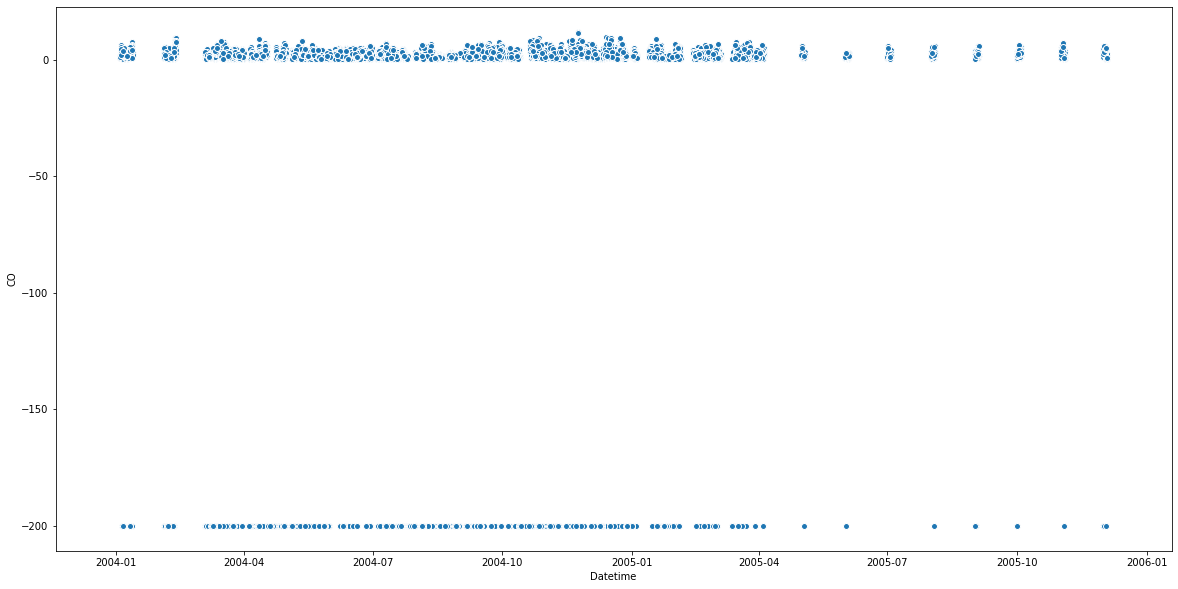

In [14]:
#Plotting CO over time
plt.figure(figsize=(20,10))
plt.scatter(dat,co, edgecolors='w')
plt.xlabel('Datetime')
plt.ylabel('CO')
plt.savefig('Plots and Graphs/q1(c1).png')
plt.show()

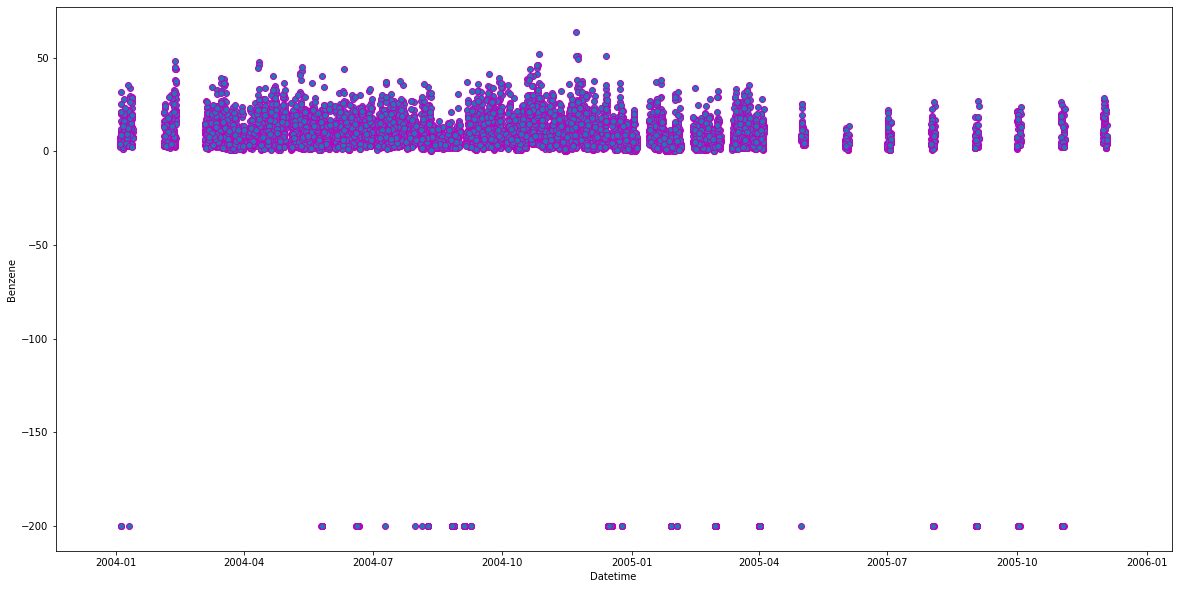

In [15]:
#Plotting Benzene over Time
plt.figure(figsize=(20,10))
plt.scatter(dat,benz, edgecolors='m' )
plt.xlabel('Datetime')
plt.ylabel('Benzene')
plt.savefig('Plots and Graphs/q1(c2).png')
plt.show()

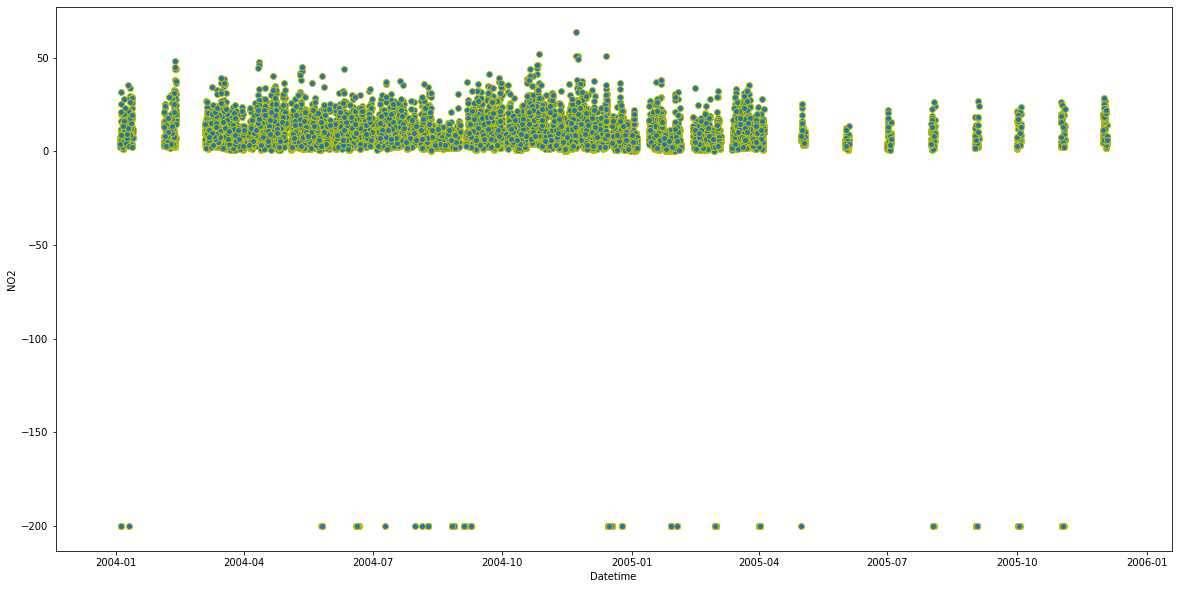

In [16]:
#Plotting NO2 over Time
plt.figure(figsize=(20,10))
plt.scatter(dat,benz, edgecolors='y' )
plt.xlabel('Datetime')
plt.ylabel('NO2')
plt.savefig('Plots and Graphs/q1(c3).png')
plt.show()

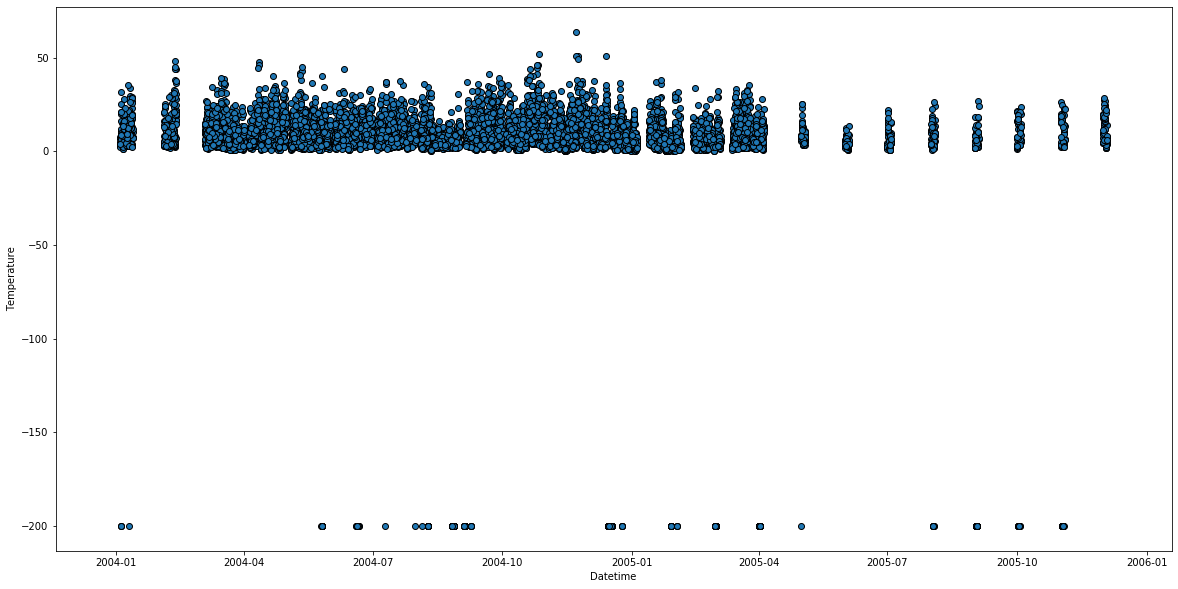

In [17]:
#Plotting Temperature over Time
plt.figure(figsize=(20,10))
plt.scatter(dat,benz, edgecolors='k' )
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.savefig('Plots and Graphs/q1(c4).png')
plt.show()

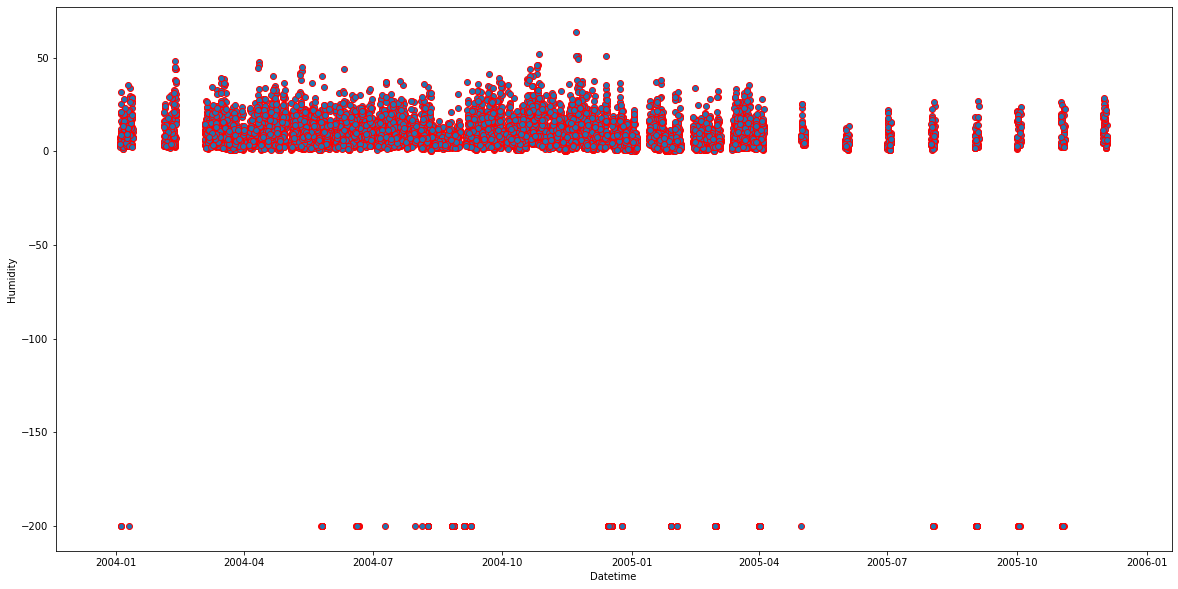

In [18]:
# #Plotting Humidity over Time
plt.figure(figsize=(20,10))
plt.scatter(dat,benz, edgecolors='r' )
plt.xlabel('Datetime')
plt.ylabel('Humidity')
plt.savefig('Plots and Graphs/q1(c5).png')
plt.show()

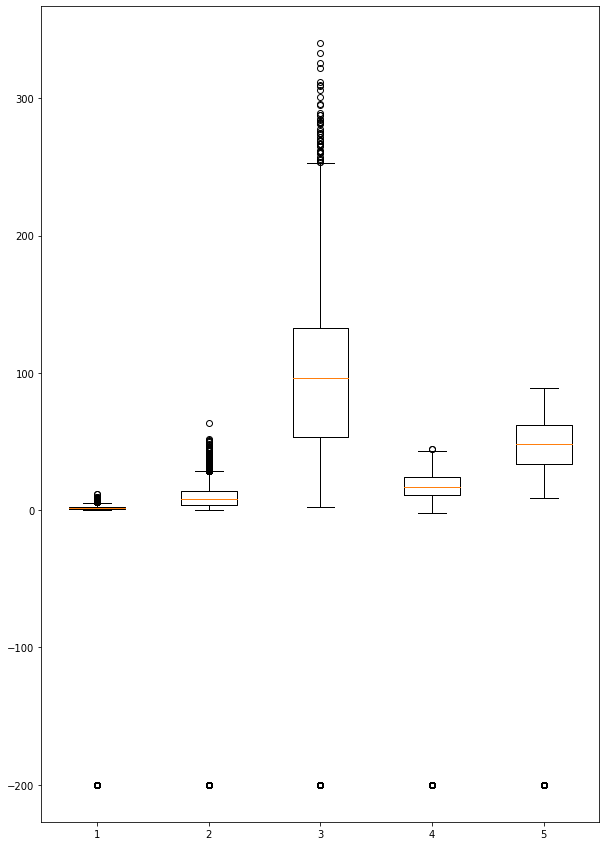

In [19]:
#Plotting Boxplots for numerical features to see overall outliers for all variables
plt.figure(figsize=(10,15))
plt.boxplot(data_to_plot)
plt.savefig('Plots and Graphs/q1(c6).png')
plt.show()

Explanation: As it is seen from the scatter plots of individual variables and boxplot, the -200 value is implausible for all five features.

(d) We need to handle any implausible or missing data. In the lecture, several strategies to do so have been introduced, for example, deleting data rows that contain missing/implausible values or replacing them by a value derived from other data points. 

In this question, consider implausible values to be the ones identified in question (c).

    1) For all numerical features, compute and show mean, standard deviation, minimum and maximum, while ignoring the missing and implausible values. Also, print the total number of data rows.
    
    2) Choose a strategy (or combination of strategies) to handle missing/implausible values. Create a cleaned data set with all those values handled accordingly.
    
    3) For all numerical features, compute and show mean, standard deviation, minimum and maximum with respect to your cleaned data set. Also print the total number of data rows.
    
    4) Motivate and explain your strategy and describe its (dis-)advantages compared to other options. Compare the computed statistical values before and after cleaning and briefly describe and evaluate any changes.

In [20]:
# Check a) again from Moodle
# What does ignoring mean here?

In [21]:
#Details about numerical variables
print("Number of rows with missing and implausible values:", dropped_new.shape[0],"\n\n")
print(dropped_new.describe())
filtered = dropped_new.drop(columns=['Datetime'])

Number of rows with missing and implausible values: 8421 


                CO      Benzene          NO2  Temperature  Humidity(%)
count  8421.000000  8421.000000  8421.000000  8421.000000  8421.000000
mean    -34.089122     1.513431    58.516566     9.383767    39.033939
std      77.567634    42.285239   126.821942    44.134084    52.246316
min    -200.000000  -200.000000  -200.000000  -200.000000  -200.000000
25%       0.600000     4.000000    53.000000    10.900000    34.000000
50%       1.500000     7.900000    96.000000    17.200000    48.400000
75%       2.600000    13.700000   133.000000    24.000000    61.900000
max      11.900000    63.700000   340.000000    44.600000    88.700000


In [22]:
#Checking if missing values exists for variables
print(filtered.isnull().sum())
#The following output shows that there exist no missing values

CO             0
Benzene        0
NO2            0
Temperature    0
Humidity(%)    0
dtype: int64


In [23]:
# mark -200 values as missing or NaN
cleaned = filtered.replace(-200, np.NaN)
print("Checking if -200 are replaced with NaN:\n", cleaned.isnull().sum())
#Using mean as a imputing strategy to replace missing values
cleaned.fillna(cleaned.mean(), inplace=True)
cleaned.shape[0]
print("\nChecking if missing values imputed successfully with mean:\n", cleaned.isnull().sum())

Checking if -200 are replaced with NaN:
 CO             1510
Benzene         345
NO2            1472
Temperature     345
Humidity(%)     345
dtype: int64

Checking if missing values imputed successfully with mean:
 CO             0
Benzene        0
NO2            0
Temperature    0
Humidity(%)    0
dtype: int64


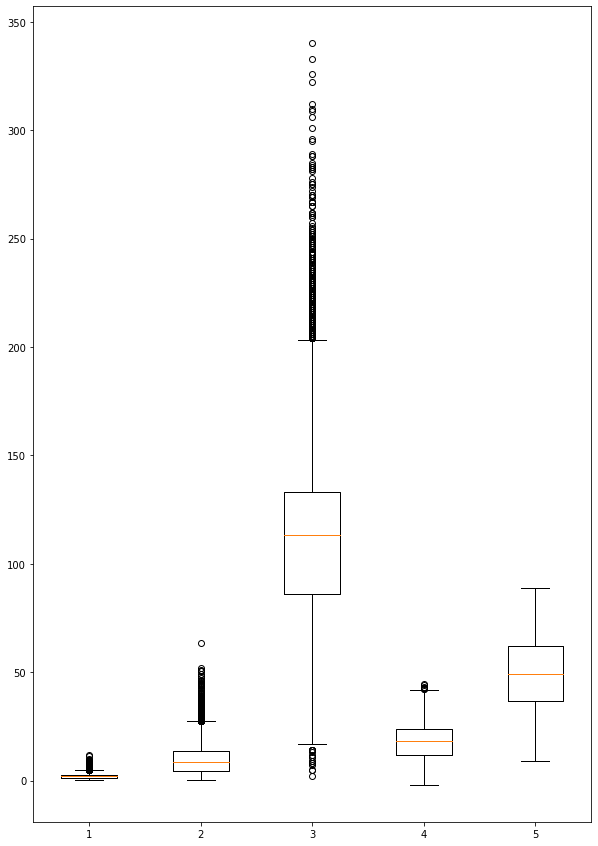

In [24]:
#Boxplot to see if implausible were removed or not
fco = cleaned['CO']
fbenz = cleaned['Benzene']
fno2 = cleaned['NO2']
ftemp = cleaned['Temperature']
fhum = cleaned['Humidity(%)']
plot_cleaned = [fco,fbenz,fno2,ftemp,fhum]

plt.figure(figsize=(10,15))
plt.boxplot(plot_cleaned)
plt.savefig('Plots and Graphs/cleaned.png')
plt.show()

In [25]:
print("Number of rows before imputing missing and implausible values:", dropped_new.shape[0],"\n\n")
print("Statistical values before imputation\n")
print(dropped_new.describe())
print("\nNumber of rows after imputing missing and implausible values:", cleaned.shape[0],"\n\n")
print("Statistical values after imputation")
print(cleaned.describe())

Number of rows before imputing missing and implausible values: 8421 


Statistical values before imputation

                CO      Benzene          NO2  Temperature  Humidity(%)
count  8421.000000  8421.000000  8421.000000  8421.000000  8421.000000
mean    -34.089122     1.513431    58.516566     9.383767    39.033939
std      77.567634    42.285239   126.821942    44.134084    52.246316
min    -200.000000  -200.000000  -200.000000  -200.000000  -200.000000
25%       0.600000     4.000000    53.000000    10.900000    34.000000
50%       1.500000     7.900000    96.000000    17.200000    48.400000
75%       2.600000    13.700000   133.000000    24.000000    61.900000
max      11.900000    63.700000   340.000000    44.600000    88.700000

Number of rows after imputing missing and implausible values: 8421 


Statistical values after imputation
                CO      Benzene          NO2  Temperature  Humidity(%)
count  8421.000000  8421.000000  8421.000000  8421.000000   8421.00000
mea

Explanation: The following is the strategy to handle the outlier values
Step 1: Replace the negative values with NaN
Step 2: Replace the NaN with mean of the feature

Changes after imputation: The mean, standard deviation and minimum values changed after imputation whrereas the maximum values for all the features are unchanged.

## Question 2 - Data Preprocessing  and Advanced Visualization (15 points)

For this question, use the extracted data set you created in the preprocessing step ('air_pollution_2.csv').

(a) To create a suitable input for the following questions, modify the data set as listed below and then print the first 5 data rows:

    - Remove the columns 'Traffic_Volume' and 'Particulate_Matter'
    - Replace the columns 'Date' and 'Time' by a combined column 'Datetime' using the datetime data type
    - Restrict the data to the timeframe between 2004-04-01 and 2005-03-31
    - Drop all rows that contain a missing value or a value below -37
    
*Hint: You may be able to reuse some of your code or data sets created above.*

In [26]:
#Reading dataset
q2 = pd.read_csv("Datasets/air_pollution_2.csv")

In [27]:
#Dropping Traffic_Volume and Particulate_Matter columns
q2 = q2.drop(columns=['Traffic_Volume', 'Particulate_Matter'])

In [28]:
#Combining date and time columns into Datetime
q2.loc[:,'Datetime'] = pd.to_datetime(q2.Date.astype(str)+' '+q2.Time.astype(str))

#Dropping date and time r columns
q2 = q2.drop(columns=['Date', 'Time'])

Number of row before filter: 8421
Number of row after filter: 4973


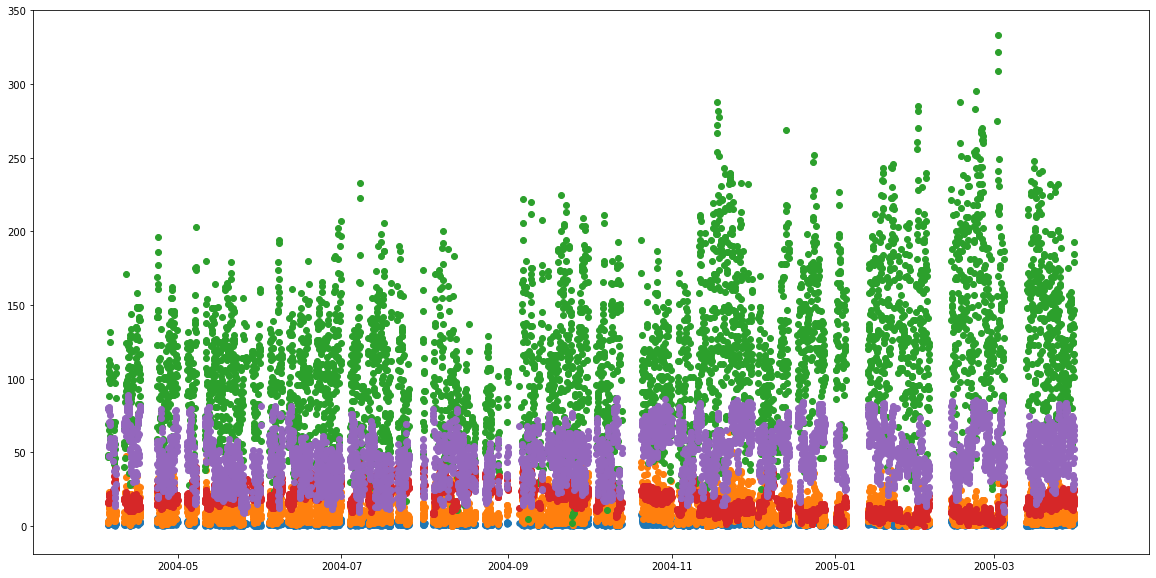

In [29]:
print("Number of row before filter:",q2.shape[0])
start_date = '2004-04-01'
end_date = '2005-03-31'
mask = (q2['Datetime'] > start_date) & (q2['Datetime'] <= end_date) & (q2['CO']>-37) & (q2['Benzene']>-37) & (q2['NO2']>-37) & (q2['Temperature']>-37) & (q2['Humidity(%)']>-37)
q2a = q2.loc[mask]
q2a = q2a[q2a.select_dtypes(include=[np.number]).ge(0).all(1)]
q2a = q2a.dropna()
print("Number of row after filter:",q2a.shape[0])
q2a.to_csv("Datasets/q2b.csv", encoding='utf-8', index=False)
# Overall distribution of all feature
plt.figure(figsize=(20,10))
plt.scatter(q2a['Datetime'], q2a['CO'], s = 30)
plt.scatter(q2a['Datetime'], q2a['Benzene'])
plt.scatter(q2a['Datetime'], q2a['NO2'])
plt.scatter(q2a['Datetime'], q2a['Temperature'])
plt.scatter(q2a['Datetime'], q2a['Humidity(%)'])
plt.savefig('Plots and Graphs/scatterover.png')
plt.show()

(b) For temperature, humidity and CO compute the mean value for each month. Create two stream graphs based on this newly computed data, that visualize the change in temperature, CO and humidity over the months:

    1) For the first stream graph, simply use the mean values you computed for each month.
    
    2) For the second stream graph, first normalize the computed mean values by mapping them individually to an interval between 0 and 1, that is, apply Min-max normalization.

In [30]:
q2b = pd.read_csv("Datasets/q2b.csv", parse_dates =["Datetime"], index_col ="Datetime")
q2b_mean = q2b.resample('M').mean() 
print("CO Monthly Mean\n",q2b_mean['CO'])
print("\nTemperature Monthly Mean\n",q2b_mean['Temperature'])
print("\nHumadity(%) Monthly Mean\n",q2b_mean['Humidity(%)'])


CO Monthly Mean
 Datetime
2004-04-30    2.555705
2004-05-31    1.910209
2004-06-30    2.003992
2004-07-31    1.945269
2004-08-31    1.601187
2004-09-30    2.323982
2004-10-31    2.513514
2004-11-30    2.548991
2004-12-31    2.477307
2005-01-31    1.924396
2005-02-28    1.925945
2005-03-31    2.182028
Freq: M, Name: CO, dtype: float64

Temperature Monthly Mean
 Datetime
2004-04-30    18.446644
2004-05-31    22.034803
2004-06-30    25.693697
2004-07-31    26.426087
2004-08-31    26.598220
2004-09-30    23.614253
2004-10-31    21.272236
2004-11-30    14.306789
2004-12-31    12.910723
2005-01-31     7.278986
2005-02-28     7.702015
2005-03-31    15.801382
Freq: M, Name: Temperature, dtype: float64

Humadity(%) Monthly Mean
 Datetime
2004-04-30    51.290268
2004-05-31    39.463805
2004-06-30    41.650420
2004-07-31    38.331202
2004-08-31    41.606825
2004-09-30    45.111086
2004-10-31    56.672482
2004-11-30    54.354679
2004-12-31    53.959352
2005-01-31    50.925362
2005-02-28    51.8347

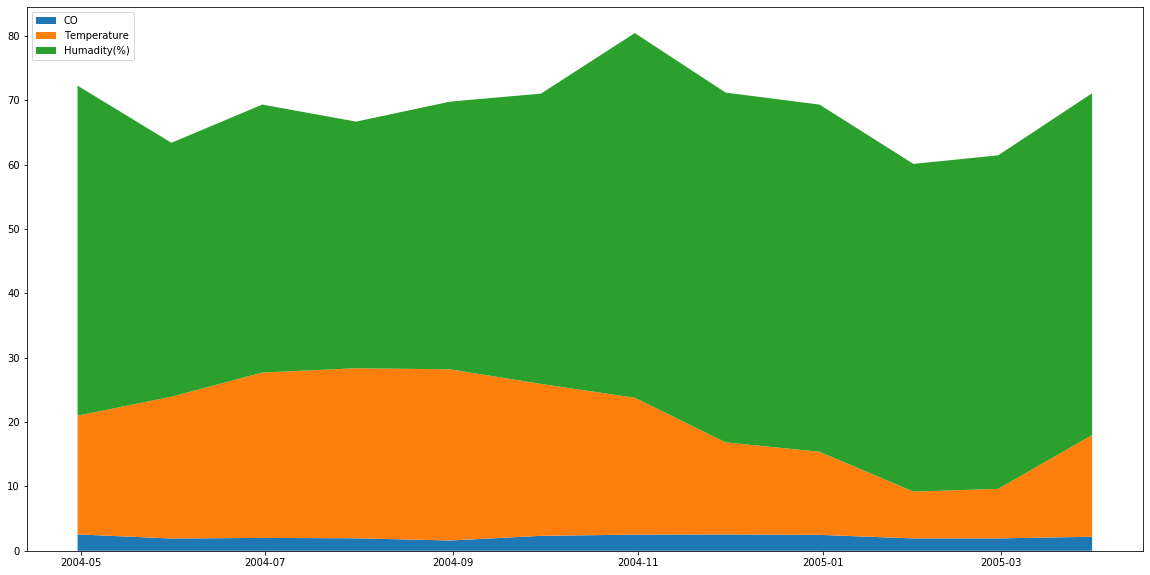

In [31]:
#Stream Graph 01
names = ["CO", "Temperature", "Humadity(%)"]
xx = list(q2b_mean.index.date)
co = q2b_mean["CO"].values
te = q2b_mean["Temperature"].values
hu = q2b_mean["Humidity(%)"].values
yy = np.vstack([co,te,hu])

fig,ax = plt. subplots(figsize = (20,10))
ax.stackplot(xx,co,te,hu, labels = names)
ax.legend(loc = 'upper left')
plt.savefig('Plots and Graphs/stream_graph01.png')
plt.show()

In [32]:
# Applying min max normalization
def normal(data):
    return (data-data.min())/(data.max() - data.min())

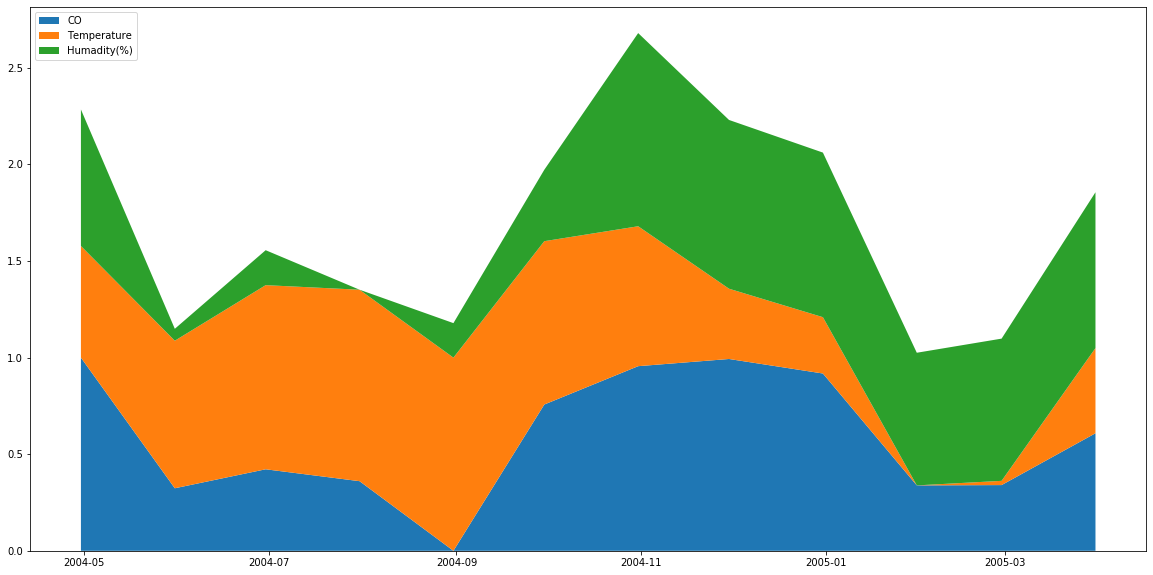

In [33]:
# Stream Graph 02
xxx = list(q2b_mean.index.date)
coo = q2b_mean["CO"].values
tee = q2b_mean["Temperature"].values
huu = q2b_mean["Humidity(%)"].values

fig,ax = plt. subplots(figsize = (20,10))
ax.stackplot(xxx,normal(coo),normal(tee),normal(huu), labels = names)
ax.legend(loc = 'upper left')
plt.savefig('Plots and Graphs/stream_graph02.png')
plt.show()

(c) Answer the following questions based on the stream graphs created in question 2(a) and briefly explain how you derived the answer. Which of the two stream graphs do you consider more adequate to obtain the answers?

    1) In which month is the average CO lowest?
    
    2) Is there any correlation between humidity and CO?
    
    3) Between which months is temperature increasing?

Explanation: The normalized stream graph provides a better understanding of features.

1) 2004-09

2) Humidity and CO are non-linearly correlated.

3) 2004-05 to 2004-09 and again from 2005-01 to 2005-02

(d) We want to create a heat map that visualizes the CO measured for different combinations of humidity and temperature. 
The heatmap should have 12 columns and 12 rows. The shown CO value should be the *median* of all values for the combination of humidity and temperature.

Modify the data as needed. Use a binning strategy of your choice for converting numerical data to categorical data. Motivate and explain all your choices and modifications.

Minimum Temperture: 0.0
Maximum Temperture: 44.6
Temperture Range: 3.716666666666667
Calcualted Range: [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]
Display Range [2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46]
------------------------------------------------------------------
Minimum Humidity: 9.2
Maximum Humidity 88.7
Humidity Range: 6.625
Calculate Range: [9, 16, 23, 30, 37, 44, 51, 58, 65, 72, 79, 86, 93]
Display Range: [12, 19, 26, 33, 40, 47, 54, 61, 68, 75, 82, 89]


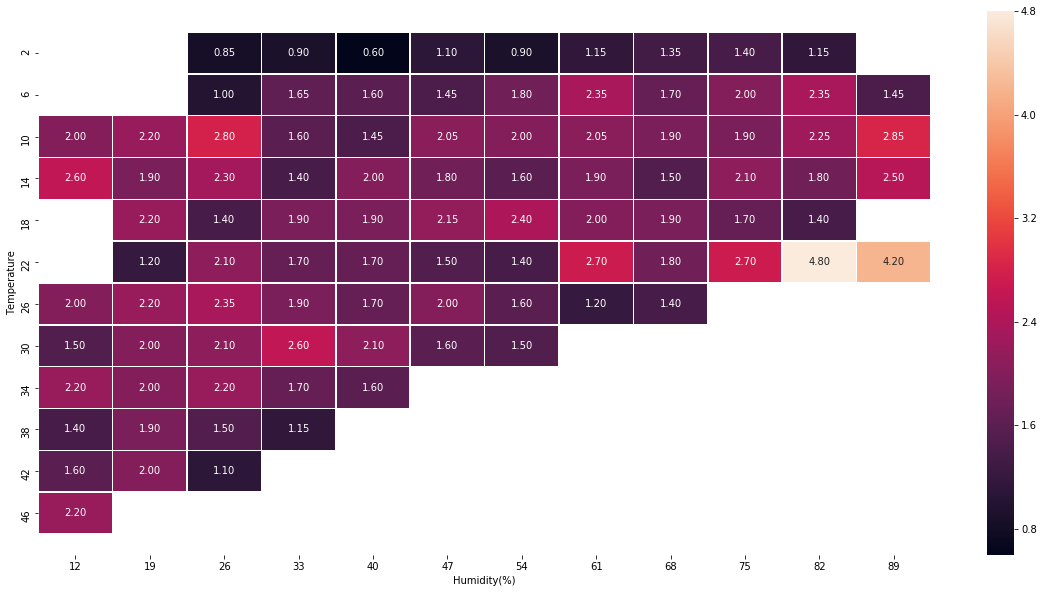

In [34]:
min_temp = q2a['Temperature'].min()
temp_max = q2a['Temperature'].max()
temp_tot_range = temp_max - min_temp
temp_12_range = temp_tot_range / 12
last = math.floor(min_temp)

temp_range_calc = [last]
for x in range(12):
    last = last + round(temp_12_range)
    temp_range_calc.append(last)
    
temp_range_disp = []
for x in range(12):
    temp_range_disp.append(math.floor((temp_range_calc[x] + temp_range_calc[x+1])/2))
    
hum_min = q2a['Humidity(%)'].min()
hum_max = q2a['Humidity(%)'].max()
hum_tot_range = hum_max - hum_min
hum_12_range = hum_tot_range / 12
last = round(hum_min)

hum_range_calc = [last]
for x in range(12):
    last = last + round(hum_12_range)
    hum_range_calc.append(last)
    
hum_range_disp = []
for x in range(12):
    hum_range_disp.append(math.floor(((hum_range_calc[x] + hum_range_calc[x+1])/2)))

disp_co = []
temp_disp = []
hum_disp = []
for x in range(12):
    co_x = []
    for y in range(12):
        temp_df = q2a[q2a['Temperature'] >= temp_range_calc[x]]
        temp_df = temp_df[temp_df['Temperature'] <= temp_range_calc[x+1]]
        temp_df = temp_df[temp_df['Humidity(%)'] >= hum_range_calc[y]]
        temp_df = temp_df[temp_df['Humidity(%)'] <= hum_range_calc[y+1]]
        co_med = temp_df['CO'].median()
        co_x.append(co_med)
    disp_co.append(co_x)

print("Minimum Temperture:", min_temp)
print("Maximum Temperture:", temp_max)
print("Temperture Range:",temp_12_range)
print("Calcualted Range:", temp_range_calc)
print("Display Range", temp_range_disp)
print("------------------------------------------------------------------")
print("Minimum Humidity:", hum_min)
print("Maximum Humidity", hum_max)
print("Humidity Range:", hum_12_range)
print("Calculate Range:", hum_range_calc)
print("Display Range:", hum_range_disp)

index = temp_range_disp
col_names = hum_range_disp
# Combining CO and Humidity
humco = pd.DataFrame(disp_co, index=index, columns = col_names)
f, ax = plt.subplots(figsize=(20, 10))
# Visualize a heatmap with the numeric values in each cell
sns.heatmap(humco, annot=True, fmt="0.2f", linewidths=.5, ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 1.0, top - 1.0)
plt.xlabel("Humidity(%)")
plt.ylabel("Temperature")
plt.savefig('Plots and Graphs/heatmap.png')
plt.show()

(e) Use the modified data to create a heat map as specified in question part (c). Answer the following questions based on that heat map and briefly explain how you derived your answer:

    1) For which combination of humidity and temperature values is the median CO highest? 
    
    2) How do you explain empty fields in your heat map?
    
    3) Is CO correlating with temperature, humidity, or both?

Explanation:

1) As seen from the graph the combination (Temperature:22 & Humidity:89) has the highest CO median

2) This possibly because of the non-numerical(NaN) values.

3) Yes, CO is correlated with both temperature and humidity.

## Question 3 - Clustering (15 points): 

(a) For this question, use the extracted data set you created in the preprocessing step ('air_pollution_2.csv'). Use a scatter diagram to find the relation between the 'Traffic_Volume' and 'Particulate_Matter' columns.

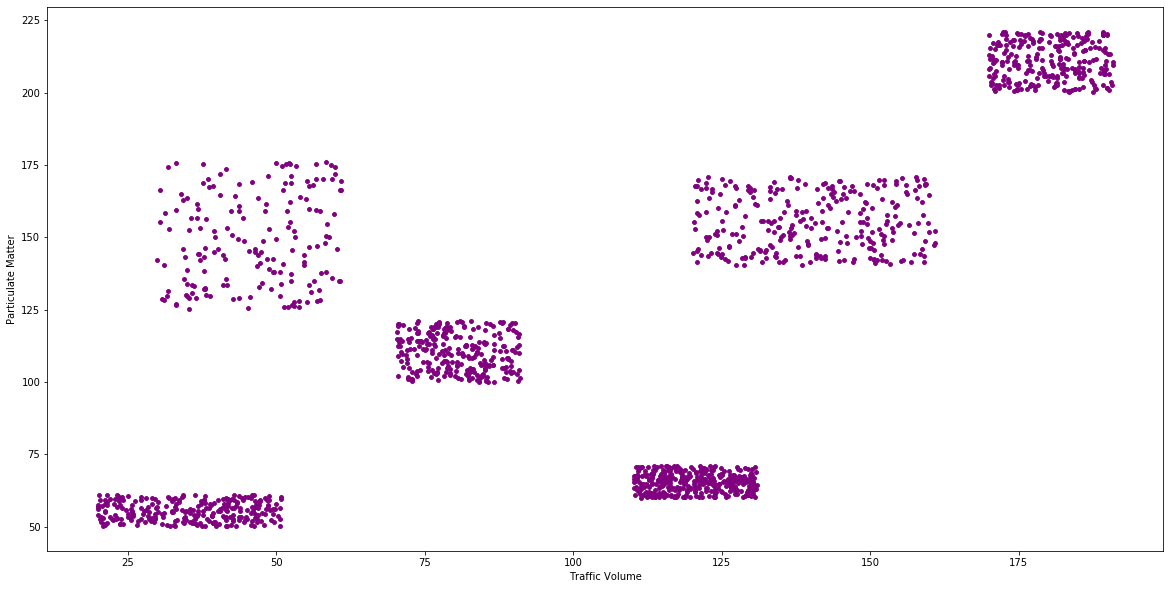

In [35]:
#Importing dataset
q3 = pd.read_csv("Datasets/air_pollution_2.csv")
#Plotting Traffic_Volume over Particulate_Matter
plt.rcParams['figure.figsize'] = (20, 10)
plt.scatter(q3['Traffic_Volume'], q3['Particulate_Matter'], c='purple', s =15)
plt.xlabel('Traffic Volume')
plt.ylabel('Particulate Matter')
plt.savefig('Plots and Graphs/clustering1.png')
plt.show()

(b) From the previous question you found the relationship between two columns which are suitable for applying clustering methods. Find the two arrays corresponding to these to columns and drop nan values from them. Apply the k_means method for clustering the two mentioned columns. Use three different number of clusters for classifying.

In [36]:
print("Observations before removing NaN",q3.shape[0])
#Removing NaN values
q3 = q3.dropna(subset = ['Traffic_Volume', 'Particulate_Matter'])
q3.head()
print("Observations after removing NaN",q3.shape[0])
tv = q3['Traffic_Volume'].values
pm = q3['Particulate_Matter'].values

Observations before removing NaN 8421
Observations after removing NaN 1607


In [37]:
#Creating two arrays
new_pollution_data = np.array(list(zip(tv, pm)))
new_pollution_data = np.reshape(new_pollution_data, (-1, 2))
print(new_pollution_data)

[[111.0725898   61.95890136]
 [ 59.94493807 174.4062931 ]
 [ 49.39814731  54.40276279]
 ...
 [ 52.30646291 175.2455423 ]
 [ 45.64118504 129.2663246 ]
 [182.6072155  200.8753704 ]]


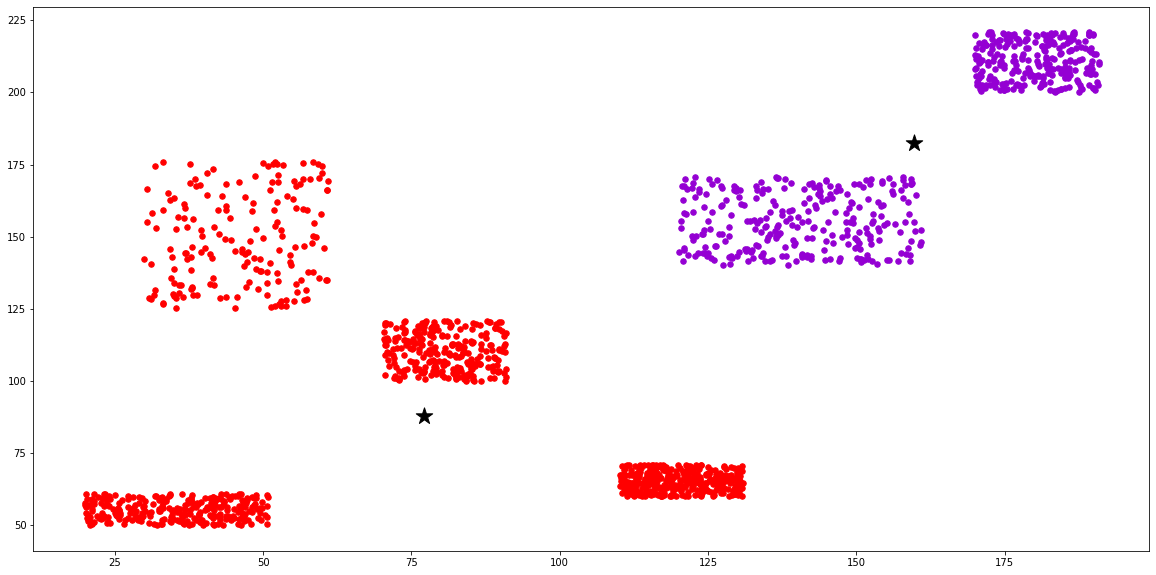

In [38]:
#k_mean algorithm with 2 clusters

cluster_num = 2
kmeans = KMeans(cluster_num).fit(new_pollution_data)
clusters = kmeans.labels_
centroids = kmeans.cluster_centers_

fig, plots = plt.subplots()
colors = ['darkviolet', 'red']
for cluster_index in range(cluster_num) :
    sub_set = np.array([new_pollution_data[i] for i in range(len(new_pollution_data)) if clusters[i] == cluster_index])
    if len(sub_set) == 0 :
        continue
    plots.scatter(sub_set[:,0], sub_set[:,1], s = 30, c = colors[cluster_index])
plots.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 300, c = 'k')
plt.savefig('Plots and Graphs/k_means1.png')
plt.show()

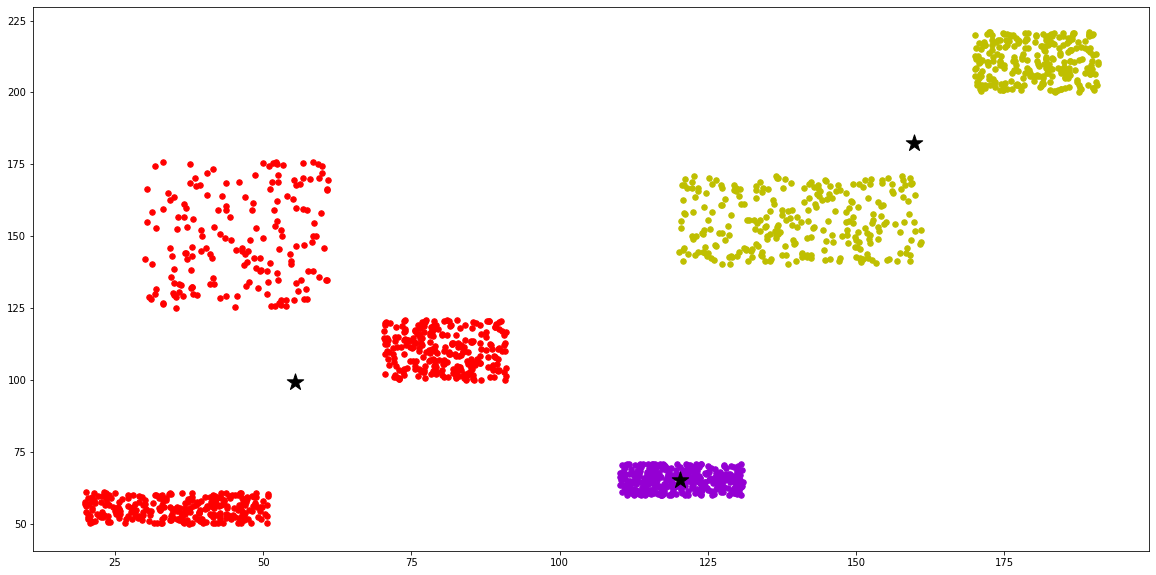

In [39]:
#k_mean algorithm with 4 clusters

cluster_num = 3
kmeans = KMeans(cluster_num).fit(new_pollution_data)
clusters = kmeans.labels_
centroids = kmeans.cluster_centers_

fig, plots = plt.subplots()
colors = ['darkviolet', 'y', 'red']
for cluster_index in range(cluster_num) :
    sub_set = np.array([new_pollution_data[i] for i in range(len(new_pollution_data)) if clusters[i] == cluster_index])
    if len(sub_set) == 0 :
        continue
    plots.scatter(sub_set[:,0], sub_set[:,1], s = 30, c = colors[cluster_index])
plots.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 300, c = 'k')
plt.savefig('Plots and Graphs/k_means2.png')
plt.show()

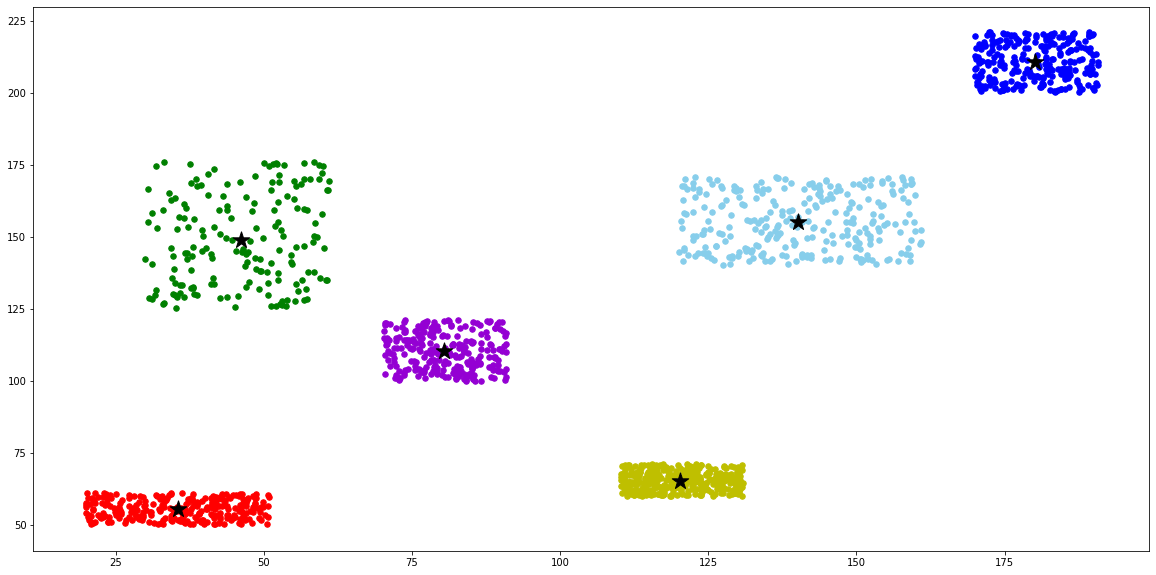

In [40]:
#k_mean algorithm for 6 clusters

cluster_num = 6
kmeans = KMeans(cluster_num).fit(new_pollution_data)
clusters = kmeans.labels_
centroids = kmeans.cluster_centers_

fig, plots = plt.subplots()
colors = ['darkviolet', 'blue', 'red', 'skyblue', 'y', 'green']
for cluster_index in range(cluster_num) :
    sub_set = np.array([new_pollution_data[i] for i in range(len(new_pollution_data)) if clusters[i] == cluster_index])
    if len(sub_set) == 0 :
        continue
    plots.scatter(sub_set[:,0], sub_set[:,1], s = 30, c = colors[cluster_index])
plots.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 300, c = 'k')
plt.savefig('Plots and Graphs/k_means3.png')
plt.show()


(c) Apply the DBSCAN method for clustering the two mentioned columns. Use three different eps and min_samples for clustering.

[-1, 0, 1, 2, 3, 4, 5]


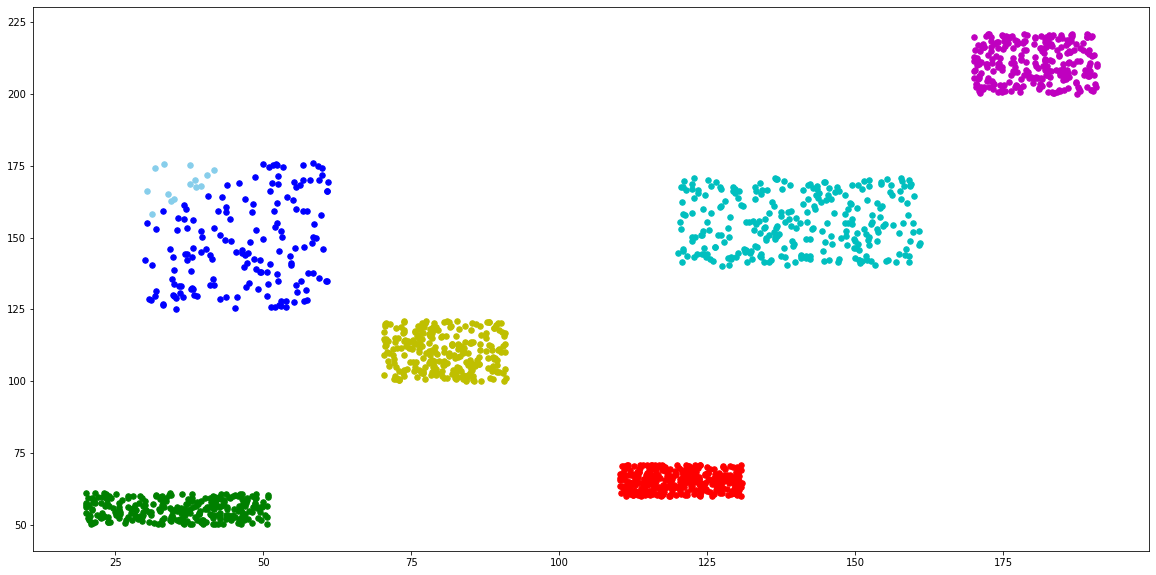

In [41]:
#DBSCAN with 10 eps
dbscan = DBSCAN(eps= 10, min_samples= 30).fit(new_pollution_data)
clusters = dbscan.labels_
cluster_indexs = np.unique(clusters).tolist()
print(cluster_indexs)

fig, plots = plt.subplots()
colors = ['r', 'g', 'b', 'y', 'm','c','k','darkviolet', 'pink', 'peru', 'bisque', 'lightcoral', 'skyblue']
for cluster_index in cluster_indexs :
    sub_set = np.array([new_pollution_data[i] for i in range(len(new_pollution_data)) if clusters[i] == cluster_index])
    if len(sub_set) == 0 :
        continue
    plots.scatter(sub_set[:,0], sub_set[:,1], s = 30, c = colors[cluster_index])
plt.savefig('Plots and Graphs/db_scan1.png')
plt.show()

[-1, 0, 1, 2, 3, 4, 5, 6]


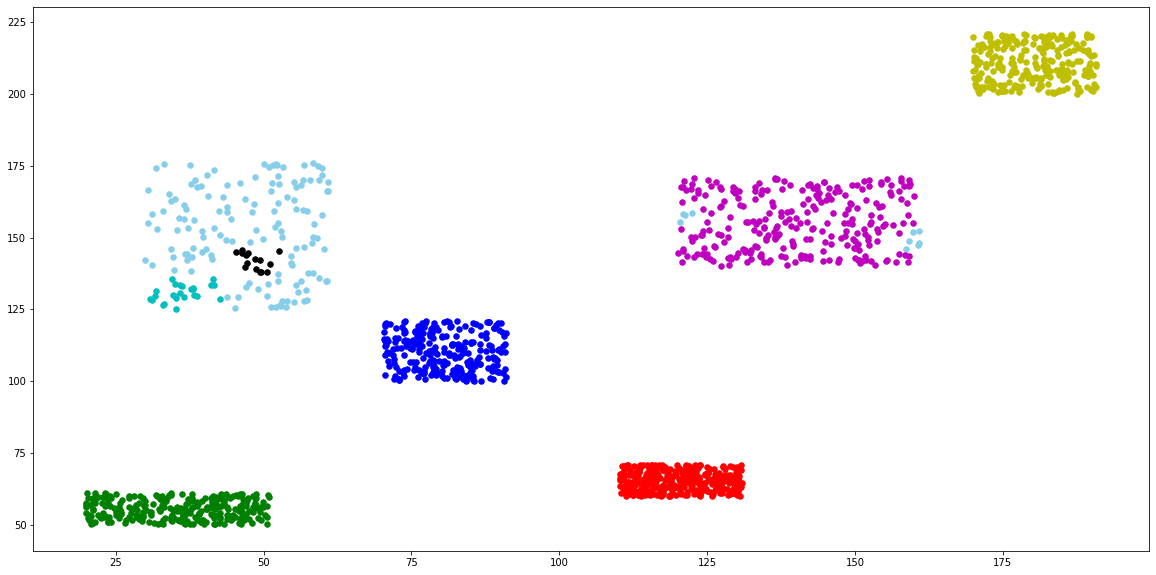

In [42]:
#DBSCAN with 5 eps
dbscan = DBSCAN(eps = 5, min_samples= 15).fit(new_pollution_data)
clusters = dbscan.labels_
cluster_indexs = np.unique(clusters).tolist()
print(cluster_indexs)

fig, plots = plt.subplots()
colors = ['r', 'g', 'b', 'y', 'm','c','k','darkviolet', 'pink', 'peru', 'bisque', 'lightcoral', 'skyblue']
for cluster_index in cluster_indexs :
    sub_set = np.array([new_pollution_data[i] for i in range(len(new_pollution_data)) if clusters[i] == cluster_index])
    if len(sub_set) == 0 :
        continue
    plots.scatter(sub_set[:,0], sub_set[:,1], s = 30, c = colors[cluster_index])
plt.savefig('Plots and Graphs/db_scan2.png')
plt.show()

[0, 1, 2, 3, 4, 5]


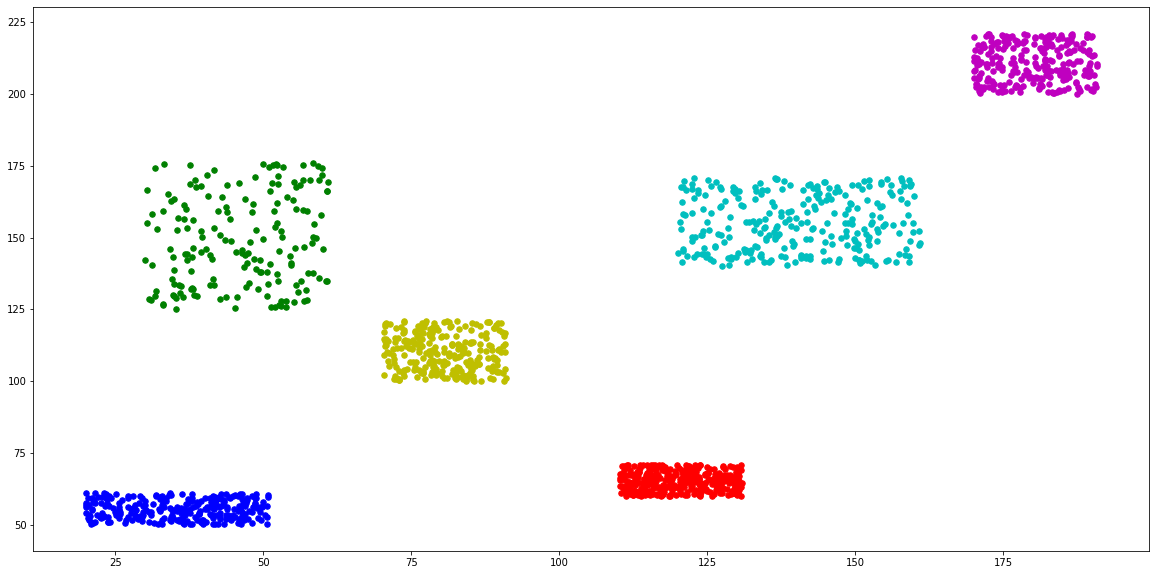

In [43]:
#DBSCAN with 8 eps
dbscan = DBSCAN(eps = 8, min_samples= 10).fit(new_pollution_data)
clusters = dbscan.labels_
cluster_indexs = np.unique(clusters).tolist()
print(cluster_indexs)

fig, plots = plt.subplots()
colors = ['r', 'g', 'b', 'y', 'm','c','k','darkviolet', 'pink', 'peru', 'bisque', 'lightcoral', 'skyblue']
for cluster_index in cluster_indexs :
    sub_set = np.array([new_pollution_data[i] for i in range(len(new_pollution_data)) if clusters[i] == cluster_index])
    if len(sub_set) == 0 :
        continue
    plots.scatter(sub_set[:,0], sub_set[:,1], s = 30, c = colors[cluster_index])
plt.savefig('Plots and Graphs/db_scan3.png')
plt.show()

(d) Compare k_means and DBSCAN results. Which of these methods is more suitable for clustering this data? Why?

K-means clustering is more suitable for clustering of this data.

Explanation: As seen in our K-means scatter plot it seems to be easier to make globular cluster using K-means because we can easily set the number of clusters where as in DBSCAN it is difficult to find values for eps and min_samples to form perfect globs.


(e) Add noise to the two mentioned columns. For adding noise, first find the range of these two columns and add a random number of 30 samples of noise in the range of each column to that. Plot the scatter diagram again.
Repeat k_means and DBSCAN algorithms for clustering. Which of these methods is more suitable for clustering this data? Why?

In [44]:
#Finding the range of traffic_volume and particulte_matter columns
tv_min = q3.Traffic_Volume.min()
tv_max = q3.Traffic_Volume.max()
pm_min = q3.Particulate_Matter.min()
pm_max = q3.Particulate_Matter.max()

#Size of columns before adding noise
print("Size before noise: ")
print("Traffic_volume = ", tv.size)
print("Particulate_matter = ", pm.size)

#Adding noise
tv_noise = np.append(tv, np.random.uniform(tv_min, tv_max, 30))
pm_noise = np.append(pm, np.random.uniform(pm_min, pm_max, 30))

#Size of columns after adding noise
print("Size after noise:")
print("Traffic_volume = ", tv_noise.size)
print("Particulate_matter = ", pm_noise.size)

Size before noise: 
Traffic_volume =  1607
Particulate_matter =  1607
Size after noise:
Traffic_volume =  1637
Particulate_matter =  1637


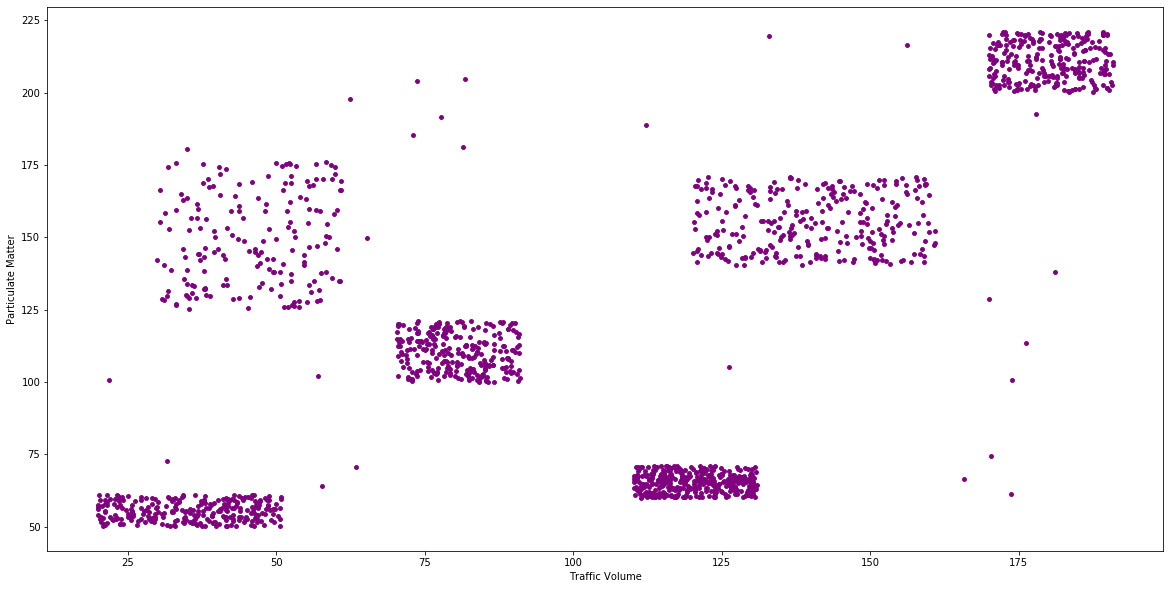

In [45]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.scatter(tv_noise, pm_noise, c='purple', s =15)
plt.xlabel('Traffic Volume')
plt.ylabel('Particulate Matter')
plt.savefig('Plots and Graphs/clustering_noise.png')
plt.show()

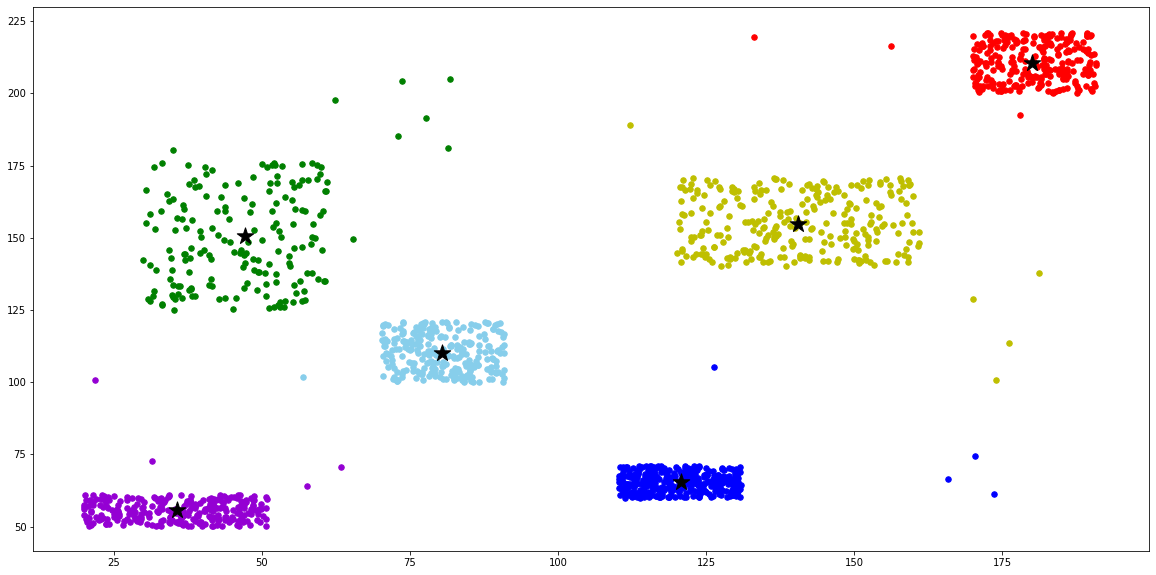

In [46]:
noise_pollution_data = np.array(list(zip(tv_noise, pm_noise)))

#k_mean algorithm for 6 clusters

cluster_num = 6
kmeans = KMeans(cluster_num).fit(noise_pollution_data)
clusters = kmeans.labels_
centroids = kmeans.cluster_centers_

fig, plots = plt.subplots()
colors = ['darkviolet', 'blue', 'red', 'skyblue', 'y', 'green']
for cluster_index in range(cluster_num) :
    sub_set = np.array([noise_pollution_data[i] for i in range(len(noise_pollution_data)) if clusters[i] == cluster_index])
    if len(sub_set) == 0 :
        continue
    plots.scatter(sub_set[:,0], sub_set[:,1], s = 30, c = colors[cluster_index])
plots.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 300, c = 'k')
plt.savefig('Plots and Graphs/k_means_noise.png')
plt.show()

[-1, 0, 1, 2, 3, 4, 5]


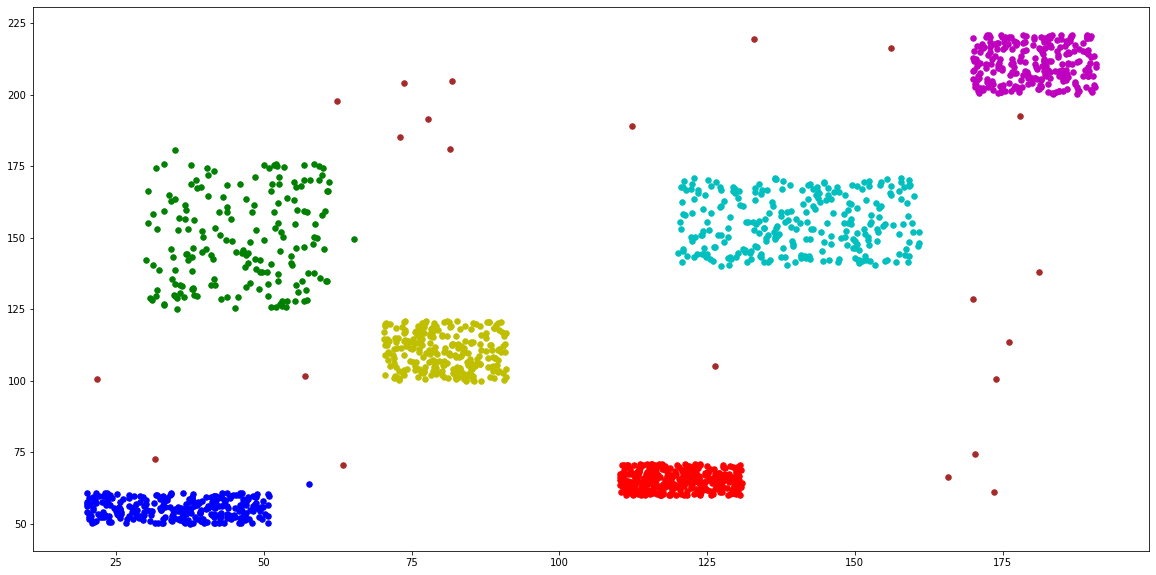

In [47]:
dbscan = DBSCAN(eps = 8, min_samples= 10).fit(noise_pollution_data)
clusters = dbscan.labels_
cluster_indexs = np.unique(clusters).tolist()
print(cluster_indexs)

fig, plots = plt.subplots()
colors = ['r', 'g', 'b', 'y', 'm','c','k','darkviolet', 'pink', 'peru', 'brown']
for cluster_index in cluster_indexs :
    sub_set = np.array([noise_pollution_data[i] for i in range(len(noise_pollution_data)) if clusters[i] == cluster_index])
    if len(sub_set) == 0 :
        continue
    plots.scatter(sub_set[:,0], sub_set[:,1], s = 30, c = colors[cluster_index])
plt.savefig('Plots and Graphs/db_scan.png')
plt.show()

DBSCAN is more suitable for clustering this data. 


Explanation:
Reason:
    One drawback of K-means is that it is sensitive to noisy data and outliers. 
    K-means clustering is done by distance based approach, so it does not recognize noisy data.

DBSCAN can identify outliers as a seperate cluster as seen in the scatter plot in the brown cluster.

## Question 4 - Frequent itemsets and association rules (15 points): 

(a) You should carry out some preprocessing steps before starting the analysis:
 - Select 90% of 'applications' dataset by random sampling. Use one of the group member's student number as a seed.
 - After completing this preprocessing step, export your final dataset as 'applications_2.csv' dataset and use that for the next steps of the assignment.
 - <font color='red'>Important!</font> Make sure that you submit your extracted dataset with your result in moodle.

In [48]:
# Your code
import pandas as pd
import csv

# Import Apriori module and TransactionEncoder module from mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules as arule

q2 = []
with open("Datasets/applications.csv") as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        new = []
        for value in row:
            if value is not None and value != '':
                new.append(value)
        q2.append(new)        
                  
#TransactionEncoder module
te = TransactionEncoder()
te_ary = te.fit(q2).transform(q2)
data1 = pd.DataFrame(te_ary, columns = te.columns_)
data1.head(5)   

pd_sample2 = data1.sample(frac=0.9, replace=False, random_state=391346)
print("Number of Rows after Sampling: ",pd_sample2.shape[0])

pd_sample2.to_csv("Datasets/applications_2.csv", encoding='utf-8', index=False)
test1 = pd.read_csv("Datasets/applications_2.csv")
test1.head()

Number of Rows after Sampling:  11778


A_ACCEPTED  A_ACTIVATED  A_APPROVED  A_CANCELLED  A_DECLINED  A_FINALIZED  \
0        True         True        True        False       False         True   
1       False        False       False         True       False        False   
2       False        False       False        False        True        False   
3       False        False       False        False        True        False   
4       False        False       False        False        True        False   

   A_PARTLYSUBMITTED  A_PREACCEPTED  A_REGISTERED  A_SUBMITTED  ...  \
0               True           True          True         True  ...   
1               True           True         False         True  ...   
2               True          False         False         True  ...   
3               True          False         False         True  ...   
4               True          False         False         True  ...   

   O_SELECTED  O_SENT  O_SENT_BACK  W_Afhandelen leads  W_Beoordelen fraude  \
0        True    True         True               False                False   
1       False   False        False                True                False   
2       False   False        False               False                False   
3       False   False        False                True                False   
4       False   False        False               False                False   

   W_Completeren aanvraag  W_Nabellen incomplete dossiers  \
0                    True                           False   
1                    True                           False   
2                   False                           False   
3                   False                           False   
4                   False                           False   

   W_Nabellen offertes  W_Valideren aanvraag  W_Wijzigen contractgegevens  
0                 True                  True                        False  
1                False                 False                        False  
2                False                 False                        False  
3                False                 False                        False  
4                False                 False                        False  

[5 rows x 24 columns]

(b) Find the most frequent itemsets with the support of more than 0.4 by using the Apriori algorithm (Hint: When you are creating rows to make the data_set, you should use none_empty strings).

In [49]:
frequent_itemsets = apriori(data1, min_support=0.4, use_colnames=True)
frequent_itemsets

support                                           itemsets
0   0.583403                                       (A_DECLINED)
1   1.000000                                (A_PARTLYSUBMITTED)
2   0.562925                                    (A_PREACCEPTED)
3   1.000000                                      (A_SUBMITTED)
4   0.562925                           (W_Completeren aanvraag)
5   0.583403                    (A_DECLINED, A_PARTLYSUBMITTED)
6   0.583403                          (A_DECLINED, A_SUBMITTED)
7   0.562925                 (A_PARTLYSUBMITTED, A_PREACCEPTED)
8   1.000000                   (A_PARTLYSUBMITTED, A_SUBMITTED)
9   0.562925        (W_Completeren aanvraag, A_PARTLYSUBMITTED)
10  0.562925                       (A_PREACCEPTED, A_SUBMITTED)
11  0.562925            (W_Completeren aanvraag, A_PREACCEPTED)
12  0.562925              (W_Completeren aanvraag, A_SUBMITTED)
13  0.583403       (A_DECLINED, A_PARTLYSUBMITTED, A_SUBMITTED)
14  0.562925    (A_PARTLYSUBMITTED, A_PREACCEPTED, A_SUBMITTED)
15  0.562925  (W_Completeren aanvraag, A_PARTLYSUBMITTED, A_...
16  0.562925  (W_Completeren aanvraag, A_PARTLYSUBMITTED, A_...
17  0.562925  (W_Completeren aanvraag, A_PREACCEPTED, A_SUBM...
18  0.562925  (W_Completeren aanvraag, A_PARTLYSUBMITTED, A_...

(c) Find the most frequent itemsets with the support of more than 0.4 by using the Apriori algorithm having more than 2 members.

In [50]:
# Your code
frequent_itemsets = apriori(data1, min_support=0.4, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
#frequent_itemsets
frequent_itemsets[ (frequent_itemsets['length'] > 2) &
                   (frequent_itemsets['support'] > 0.4) ]

support                                           itemsets  length
13  0.583403       (A_DECLINED, A_PARTLYSUBMITTED, A_SUBMITTED)       3
14  0.562925    (A_PARTLYSUBMITTED, A_PREACCEPTED, A_SUBMITTED)       3
15  0.562925  (W_Completeren aanvraag, A_PARTLYSUBMITTED, A_...       3
16  0.562925  (W_Completeren aanvraag, A_PARTLYSUBMITTED, A_...       3
17  0.562925  (W_Completeren aanvraag, A_PREACCEPTED, A_SUBM...       3
18  0.562925  (W_Completeren aanvraag, A_PARTLYSUBMITTED, A_...       4

(d) Find the itemsets having min_confidence=0.3 and min_lift=1.2. Print support, confidence and lift of filtered rules in one table.

In [51]:
#your code
from mlxtend.frequent_patterns import association_rules
frequent_itemsets = apriori(data1, min_support=0.4, use_colnames = True)
#association rules
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules=association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules

antecedents  \
0                            (W_Completeren aanvraag)   
1                                     (A_PREACCEPTED)   
2         (W_Completeren aanvraag, A_PARTLYSUBMITTED)   
3                  (A_PARTLYSUBMITTED, A_PREACCEPTED)   
4                            (W_Completeren aanvraag)   
5                                     (A_PREACCEPTED)   
6               (W_Completeren aanvraag, A_SUBMITTED)   
7                        (A_PREACCEPTED, A_SUBMITTED)   
8                            (W_Completeren aanvraag)   
9                                     (A_PREACCEPTED)   
10  (W_Completeren aanvraag, A_PARTLYSUBMITTED, A_...   
11    (A_PARTLYSUBMITTED, A_PREACCEPTED, A_SUBMITTED)   
12        (W_Completeren aanvraag, A_PARTLYSUBMITTED)   
13              (W_Completeren aanvraag, A_SUBMITTED)   
14                 (A_PARTLYSUBMITTED, A_PREACCEPTED)   
15                       (A_PREACCEPTED, A_SUBMITTED)   
16                           (W_Completeren aanvraag)   
17                                    (A_PREACCEPTED)   

                                          consequents  antecedent support  \
0                                     (A_PREACCEPTED)            0.562925   
1                            (W_Completeren aanvraag)            0.562925   
2                                     (A_PREACCEPTED)            0.562925   
3                            (W_Completeren aanvraag)            0.562925   
4                  (A_PARTLYSUBMITTED, A_PREACCEPTED)            0.562925   
5         (W_Completeren aanvraag, A_PARTLYSUBMITTED)            0.562925   
6                                     (A_PREACCEPTED)            0.562925   
7                            (W_Completeren aanvraag)            0.562925   
8                        (A_PREACCEPTED, A_SUBMITTED)            0.562925   
9               (W_Completeren aanvraag, A_SUBMITTED)            0.562925   
10                                    (A_PREACCEPTED)            0.562925   
11                           (W_Completeren aanvraag)            0.562925   
12                       (A_PREACCEPTED, A_SUBMITTED)            0.562925   
13                 (A_PARTLYSUBMITTED, A_PREACCEPTED)            0.562925   
14              (W_Completeren aanvraag, A_SUBMITTED)            0.562925   
15        (W_Completeren aanvraag, A_PARTLYSUBMITTED)            0.562925   
16    (A_PARTLYSUBMITTED, A_PREACCEPTED, A_SUBMITTED)            0.562925   
17  (W_Completeren aanvraag, A_PARTLYSUBMITTED, A_...            0.562925   

    consequent support   support  confidence      lift  leverage  conviction  
0             0.562925  0.562925         1.0  1.776435   0.24604         inf  
1             0.562925  0.562925         1.0  1.776435   0.24604         inf  
2             0.562925  0.562925         1.0  1.776435   0.24604         inf  
3             0.562925  0.562925         1.0  1.776435   0.24604         inf  
4             0.562925  0.562925         1.0  1.776435   0.24604         inf  
5             0.562925  0.562925         1.0  1.776435   0.24604         inf  
6             0.562925  0.562925         1.0  1.776435   0.24604         inf  
7             0.562925  0.562925         1.0  1.776435   0.24604         inf  
8             0.562925  0.562925         1.0  1.776435   0.24604         inf  
9             0.562925  0.562925         1.0  1.776435   0.24604         inf  
10            0.562925  0.562925         1.0  1.776435   0.24604         inf  
11            0.562925  0.562925         1.0  1.776435   0.24604         inf  
12            0.562925  0.562925         1.0  1.776435   0.24604         inf  
13            0.562925  0.562925         1.0  1.776435   0.24604         inf  
14            0.562925  0.562925         1.0  1.776435   0.24604         inf  
15            0.562925  0.562925         1.0  1.776435   0.24604         inf  
16            0.562925  0.562925         1.0  1.776435   0.24604         inf  
17            0.562925  0.562925         1.0  1.776435   0.24604        

In [52]:
#printing support, confidence and lift of filtered rules
final=rules[['support','confidence','lift']]
final

support  confidence      lift
0   0.562925         1.0  1.776435
1   0.562925         1.0  1.776435
2   0.562925         1.0  1.776435
3   0.562925         1.0  1.776435
4   0.562925         1.0  1.776435
5   0.562925         1.0  1.776435
6   0.562925         1.0  1.776435
7   0.562925         1.0  1.776435
8   0.562925         1.0  1.776435
9   0.562925         1.0  1.776435
10  0.562925         1.0  1.776435
11  0.562925         1.0  1.776435
12  0.562925         1.0  1.776435
13  0.562925         1.0  1.776435
14  0.562925         1.0  1.776435
15  0.562925         1.0  1.776435
16  0.562925         1.0  1.776435
17  0.562925         1.0  1.776435

## Question 5 - Text Mining (15 points)

Among the datasets given for this assignment you will find the files "pg_train" and "pg_test". These two files contain a labeled corpus, already splitted in training and test set.
The corpus consists of sentences from several novels, labeled with the name of the author. The first task is text classification: you will train a set of classifiers that predict the author of a piece of text.

(a) Perform preprocessing on the training corpus (all lowercase, no punctuation, tokenization, stemming, stopword removal) and obtain a binary document-term matrix; train a logistic classifier with the author as target.

In [130]:
# your code
# nltk's default stoplist:
import pandas as pd
import re
from nltk import FreqDist
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer, PorterStemmer
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metric
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

snowball_stemmer = SnowballStemmer('english', ignore_stopwords=True)
stoplist = set(stopwords.words('english'))

corpus= []
target = []
data = []
clean_data = []
tokenized_data =[]
final_data = []

with open('Datasets/pg_train.csv') as f:
    corpus.append(f.readlines())

for line in corpus:
    for words in line:
#         Lower-case transformation
        words = words.casefold()                                                   
        index = words.find('#')
        target.append(words[0:index])
        #print(words[0:index])
        data.append(words[index+1:-1])
        #print(words[index+1:-1])

target = [x for x in target if len(x.strip()) > 0]                      
data = [x for x in data if len(x.strip()) > 0]

for value in data:
    #Remove punctuation and tokenize
    tokenized_data.append(re.findall(r'\w+', value))                                
 
for value in tokenized_data:
    #Stopword Removal
    clean_data.append([w for w in value if not w in stoplist])

for value in clean_data:    
    #Stemming
    final_data.append(' '.join([snowball_stemmer.stem(word) for word in value]))    

vec = CountVectorizer()
trans = vec.fit_transform(final_data)
df_res2 = pd.DataFrame(trans.toarray(), columns=vec.get_feature_names())

df_res1 = df_res2.apply(lambda x: [y if y <= 1 else 1 for y in x])

clf_1 = LogisticRegression()
clf_1.fit(df_res1, target)
#clf_1 = MLPClassifier(activation='logistic')
#clf_1.fit(df_res1, target)

#print(df_res1.shape)
display('Binary Document-term Matrix',df_res2)

C:\Users\Mubashir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Mubashir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


'Binary Document-term Matrix\n'

000  10  11  119  12  13  1350  14  15  1599  ...  zeal  zealous  zem  \
0       0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
1       0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
2       0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
3       0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
4       0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
...   ...  ..  ..  ...  ..  ..   ...  ..  ..   ...  ...   ...      ...  ...   
4494    0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
4495    0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
4496    0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
4497    0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
4498    0   0   0    0   0   0     0   0   0     0  ...     0        0    0   

      zigzag  zmite  zoetrop  zola  zoolog  zso  zumpt  
0          0      0        0     0       0    0      0  
1          0      0        0     0       0    0      0  
2          0      0        0     0       0    0      0  
3          0      0        0     0       0    0      0  
4          0      0        0     0       0    0      0  
...      ...    ...      ...   ...     ...  ...    ...  
4494       0      0        0     0       0    0      0  
4495       0      0        0     0       0    0      0  
4496       0      0        0     0       0    0      0  
4497       0      0        0     0       0    0      0  
4498       0      0        0     0       0    0      0  

[4499 rows x 11665 columns]

(b) Perform preprocessing on the training corpus (all lowercase, no punctuation, tokenization, stemming, stopword removal) and obtain a document-term matrix of counts; train a logistic classifier with the author as target.

In [113]:
clf_2 = LogisticRegression()
clf_2.fit(df_res2, target)
display('Document-term Matrix of Counts', df_res2)

C:\Users\Mubashir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Mubashir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


000  10  11  119  12  13  1350  14  15  1599  ...  zeal  zealous  zem  \
0       0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
1       0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
2       0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
3       0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
4       0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
...   ...  ..  ..  ...  ..  ..   ...  ..  ..   ...  ...   ...      ...  ...   
4494    0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
4495    0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
4496    0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
4497    0   0   0    0   0   0     0   0   0     0  ...     0        0    0   
4498    0   0   0    0   0   0     0   0   0     0  ...     0        0    0   

      zigzag  zmite  zoetrop  zola  zoolog  zso  zumpt  
0          0      0        0     0       0    0      0  
1          0      0        0     0       0    0      0  
2          0      0        0     0       0    0      0  
3          0      0        0     0       0    0      0  
4          0      0        0     0       0    0      0  
...      ...    ...      ...   ...     ...  ...    ...  
4494       0      0        0     0       0    0      0  
4495       0      0        0     0       0    0      0  
4496       0      0        0     0       0    0      0  
4497       0      0        0     0       0    0      0  
4498       0      0        0     0       0    0      0  

[4499 rows x 11665 columns]

(c) Perform preprocessing on the training corpus (all lowercase, no punctuation, tokenization, stemming, stopword removal) and obtain a tf-idf scores document-term matrix; train a logistic classifier.


In [114]:
# your code
column_values = []

flat_data  = [val for sublist in clean_data for val in sublist]
words_data = list(set(flat_data))

tfidf = TfidfVectorizer(vocabulary = words_data)
tfs = tfidf.fit_transform(final_data)
    
feature_names = tfidf.get_feature_names()
##final_data_index = [n for n in final_data]

for i,value in enumerate(final_data):
    column_values.append(i)
df_res3 = pd.DataFrame(tfs.todense(), index=column_values, columns=feature_names)

clf_3 = LogisticRegression()
clf_3.fit(df_res3, target)

#print(df_res3.shape)
# display("tf-idf Document-term Matrix", df_res3)

C:\Users\Mubashir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Mubashir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


'tf-idf Document-term Matrix'

filing  reintroduction   45  twin  epitaph  dismay  recoiled  glamis  \
0        0.0             0.0  0.0   0.0      0.0     0.0       0.0     0.0   
1        0.0             0.0  0.0   0.0      0.0     0.0       0.0     0.0   
2        0.0             0.0  0.0   0.0      0.0     0.0       0.0     0.0   
3        0.0             0.0  0.0   0.0      0.0     0.0       0.0     0.0   
4        0.0             0.0  0.0   0.0      0.0     0.0       0.0     0.0   
...      ...             ...  ...   ...      ...     ...       ...     ...   
4494     0.0             0.0  0.0   0.0      0.0     0.0       0.0     0.0   
4495     0.0             0.0  0.0   0.0      0.0     0.0       0.0     0.0   
4496     0.0             0.0  0.0   0.0      0.0     0.0       0.0     0.0   
4497     0.0             0.0  0.0   0.0      0.0     0.0       0.0     0.0   
4498     0.0             0.0  0.0   0.0      0.0     0.0       0.0     0.0   

      flaps  worthyest  ...  apoplectic  argument  ouercome  humming  false  \
0       0.0        0.0  ...         0.0       0.0       0.0      0.0    0.0   
1       0.0        0.0  ...         0.0       0.0       0.0      0.0    0.0   
2       0.0        0.0  ...         0.0       0.0       0.0      0.0    0.0   
3       0.0        0.0  ...         0.0       0.0       0.0      0.0    0.0   
4       0.0        0.0  ...         0.0       0.0       0.0      0.0    0.0   
...     ...        ...  ...         ...       ...       ...      ...    ...   
4494    0.0        0.0  ...         0.0       0.0       0.0      0.0    0.0   
4495    0.0        0.0  ...         0.0       0.0       0.0      0.0    0.0   
4496    0.0        0.0  ...         0.0       0.0       0.0      0.0    0.0   
4497    0.0        0.0  ...         0.0       0.0       0.0      0.0    0.0   
4498    0.0        0.0  ...         0.0       0.0       0.0      0.0    0.0   

      bankes  enigma  _gibson  originating  dared  
0        0.0     0.0      0.0          0.0    0.0  
1        0.0     0.0      0.0          0.0    0.0  
2        0.0     0.0      0.0          0.0    0.0  
3        0.0     0.0      0.0          0.0    0.0  
4        0.0     0.0      0.0          0.0    0.0  
...      ...     ...      ...          ...    ...  
4494     0.0     0.0      0.0          0.0    0.0  
4495     0.0     0.0      0.0          0.0    0.0  
4496     0.0     0.0      0.0          0.0    0.0  
4497     0.0     0.0      0.0          0.0    0.0  
4498     0.0     0.0      0.0          0.0    0.0  

[4499 rows x 19427 columns]

(d) Perform preprocessing on the training corpus (all lowercase, no punctuation, tokenization, stemming, stopword removal) and obtain a doc2vec embedding in order to reduce the dimension of the document vector to 300; use the doc2vec model you just trained to convert the training set to a set of document vectors; train a logistic classifier with the author as target.


In [115]:
# your code
doc2vec_data = []
reduced_dim_data = []

#Data is tokenised again for Doc2Vec
for value in final_data:
    doc2vec_data.append(re.findall(r'\w+', value))  

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_data)]
model = Doc2Vec(documents, vector_size=300, window=2, min_count=1, workers=4)

for sentence in doc2vec_data:
    reduced_dim_data.append(model.infer_vector(sentence))

#print(len(reduced_dim_data))
df_res4 = pd.DataFrame(reduced_dim_data)

clf_4 = LogisticRegression()
clf_4.fit(df_res4, target)
#print('doc2vec Embedding',df_res4.shape)

C:\Users\Mubashir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Mubashir\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

(e) Predict the classification with the four models on the test data.

In [123]:
with open("Datasets/pg_test.csv") as f:
    corpus.append(f.readlines())

snowball_stemmer = SnowballStemmer('english', ignore_stopwords=True)
stoplist = set(stopwords.words('english'))

target_test = []
data_test = []
clean_data_test = []
tokenized_data_test =[]
final_data_test = []

df_pred1 = pd.DataFrame()
df_pred2 = pd.DataFrame()
df_pred3 = pd.DataFrame()

for line in corpus:
    for words in line:
        words = words.casefold()                                                    #Converting to lowercase
        index = words.find('#')
        target_test.append(words[0:index])
        #print(words[0:index])
        data_test.append(words[index+1:-1])
        #print(words[index+1:-1])

target_test = [x for x in target_test if len(x.strip()) > 0]                      
data_test = [x for x in data_test if len(x.strip()) > 0]

for value in data_test:
    tokenized_data_test.append(re.findall(r'\w+', value))                                #Remove punctuation and tokenize
 
for value in tokenized_data_test:                                                        #Stopword Removal
    clean_data_test.append([w for w in value if not w in stoplist])

for value in clean_data_test:                                                            #Stemming
    final_data_test.append(' '.join([snowball_stemmer.stem(word) for word in value]))
    
vec = CountVectorizer()
tran = vec.fit_transform(final_data_test)
df_temp_2 = pd.DataFrame(tran.toarray(), columns=vec.get_feature_names())
df_temp_1 = df_temp_2.apply(lambda x: [y if y <= 1 else 1 for y in x])



#Prediction using binary document term matrix
corpus_columns = df_res1.columns

for col in df_temp_1:
    if corpus_columns.contains(col):
        df_pred1[col] = df_temp_1[col]

#print(df_pred1.shape)
feature_difference = set(df_res1) - set(df_pred1)
feature_difference_df = pd.DataFrame(data=np.zeros((df_pred1.shape[0], len(feature_difference))),
                                     columns=list(feature_difference))
df_pred1 = df_pred1.join(feature_difference_df)
#print(df_pred1.shape)
predicted1 = clf_1.predict(df_pred1)



#Prediction using document term matrix

for col in df_temp_2:
    if corpus_columns.contains(col):
        df_pred2[col] = df_temp_2[col]

#print(df_pred1.shape)
feature_difference = set(df_res2) - set(df_pred2)
feature_difference_df = pd.DataFrame(data=np.zeros((df_pred2.shape[0], len(feature_difference))),
                                     columns=list(feature_difference))
df_pred2 = df_pred2.join(feature_difference_df)
#print(df_pred1.shape)
predicted2 = clf_2.predict(df_pred2)



#Prediction using tf-idf document term matrix

column_values = []
corpus_columns = df_res3.columns

flat_data  = [val for sublist in clean_data_test for val in sublist]
words_data = list(set(flat_data))

tfidf = TfidfVectorizer(vocabulary = words_data)
tfs = tfidf.fit_transform(final_data_test)
    
feature_names = tfidf.get_feature_names()
##final_data_index = [n for n in final_data]

for i,value in enumerate(final_data_test):
    column_values.append(i)
df_pred_3 = pd.DataFrame(tfs.todense(), index=column_values, columns=feature_names)

#print(df_pred_3.head())

for col in df_pred_3:
    if corpus_columns.contains(col):
        df_pred3[col] = df_pred_3[col]

#print(df_res3.shape)
feature_difference = set(df_res3) - set(df_pred3)
feature_difference_df = pd.DataFrame(data=np.zeros((df_pred3.shape[0], len(feature_difference))),
                                     columns=list(feature_difference))
df_pred3 = df_pred3.join(feature_difference_df)

#print(df_pred3.shape)

predicted3 = clf_3.predict(df_pred3)



#Prediction using doc2vec
doc2vec_data = []
reduced_dim_data = []

#Data is tokenised again for Doc2Vec
for value in final_data_test:
    doc2vec_data.append(re.findall(r'\w+', value))  

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc2vec_data)]
model = Doc2Vec(documents, vector_size=300, window=2, min_count=1, workers=4)

for sentence in doc2vec_data:
    reduced_dim_data.append(model.infer_vector(sentence))

#print(len(reduced_dim_data))
df_pred4 = pd.DataFrame(reduced_dim_data)

predicted4 = clf_4.predict(df_pred4)

C:\Users\Mubashir\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: The 'contains' method is deprecated and will be removed in a future version. Use 'key in index' instead of 'index.contains(key)'
C:\Users\Mubashir\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: The 'contains' method is deprecated and will be removed in a future version. Use 'key in index' instead of 'index.contains(key)'
C:\Users\Mubashir\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: FutureWarning: The 'contains' method is deprecated and will be removed in a future version. Use 'key in index' instead of 'index.contains(key)'


In [127]:
display("Classification of Binary Document Term Matrix", predicted1)
display("Classification of Document Term Matrix", predicted2)
display("Classification of tf-idf Document Term Matrix", predicted3)
display("Classification of doc2vec", predicted4)

'Classification of Binary Document Term Matrix'

array(['shakespeare', 'shakespeare', 'shakespeare', ..., 'shakespeare',
       'shakespeare', 'shakespeare'], dtype='<U11')

'Classification of Document Term Matrix'

array(['shakespeare', 'shakespeare', 'shakespeare', ..., 'shakespeare',
       'shakespeare', 'shakespeare'], dtype='<U11')

'Classification of tf-idf Document Term Matrix'

array(['chesterton', 'chesterton', 'chesterton', ..., 'chesterton',
       'chesterton', 'chesterton'], dtype='<U11')

'Classification of doc2vec'

array(['chesterton', 'chesterton', 'austen', ..., 'shakespeare',
       'chesterton', 'shakespeare'], dtype='<U11')

(f) Obtain confusion matrices for the four different models.


In [128]:
from sklearn.metrics import classification_report, confusion_matrix 
print("Confusion Matrix for classifier using binary document term matrix")
print(confusion_matrix(target_test, predicted1))

print("Confusion Matrix for classifier using document term matrix")
print(confusion_matrix(target_test, predicted2))

print("Confusion Matrix for classifier using tf-idf document term matrix")
print(confusion_matrix(target_test, predicted3))

print("Confusion Matrix for classifier using doc2vec")
print(confusion_matrix(target_test, predicted4))

Confusion Matrix for classifier using binary document term matrix
[[  18  210 1839]
 [   9   75 1461]
 [   0    3  900]]
Confusion Matrix for classifier using document term matrix
[[  75  207 1785]
 [  27   81 1437]
 [   0    3  900]]
Confusion Matrix for classifier using tf-idf document term matrix
[[   3 1878  186]
 [   3 1428  114]
 [  15  795   93]]
Confusion Matrix for classifier using doc2vec
[[988 806 273]
 [139 870 536]
 [192 228 483]]


(g) Obtain accuracy and f1-score for the four different models.


In [24]:
print("Accuracy using binary document term matrix")
print(metric.accuracy_score(target_test, predicted1, normalize=True))
print(classification_report(target_test, predicted1))

print("Accuracy using document term matrix")
print(metric.accuracy_score(target_test, predicted2, normalize=True))
print(classification_report(target_test, predicted2))

print("Accuracy using tf-idf document term matrix")
print(metric.accuracy_score(target_test, predicted3, normalize=True))
print(classification_report(target_test, predicted3))

print("Accuracy using doc2vec")
print(metric.accuracy_score(target_test, predicted4, normalize=True))
print(classification_report(target_test, predicted4))

(h) Briefly comment on the quality of the predictions for the four models.

Explanation:

The Binary Document Term Matrix and doc2vec models result in higher precision as compared to Document Term Matrix and tf-idf.


(i) For the two authors Austen and Chesterton separately, build a bigram language model. You should use both training and test data to build the model. Do not perform stemming or stopword removal for this task, but do use the other preprocessing steps described in (a). Use both right and left padding, and manage unknown terms by using a dedicated token.

In [53]:
# Your code

(j) For each author, use the correspondent language models from (i) to generate, using MLE, a sentence of fifteen words starting from each of the following terms:

In [58]:
'She'
'They'
'It'

(k) Now, computer another two models (for Austen and Chesterton separately), build a trigram model with the same data as in (i). Use both right and left padding, and manage unknown terms by using a dedicated token.

In [55]:
# Your code

(l) For each author, use the correspondent language models from (k) to generate, using MLE, a sentence of fifteen words starting from each of the same terms as question (j):

In [56]:
# Your code

(m) Comment on the quality of the models and generated text. Which model performs better? In general, which differences are there in using trigrams as opposed to bigrams?

Explanation:


## Question 6 - Process Mining (15 points)
For this part, refer to the online docs of pm4py (https://pm4py.fit.fraunhofer.de/).
Important: if you did not do it in the instruction, you should make sure to have the latest pm4py version: to get it is sufficient to type `pip install pm4py --upgrade`.
In this section of the assignment you will be working with a real life event log, derived from the activity of the help desk department of an Italian software company. The data is contained in the file "event_log.xes".

(a) Use the provided event log and identify the least frequent variant and the most frequent variant.


In [3]:
log = xes_import_factory.import_log('Datasets/event_log.xes')

In [4]:
count_var = case_statistics.get_variant_statistics(log)
sorted_var = sorted(count_var, key=lambda x: x['count'], reverse=True)
count_max = sorted_var[0]['count']
count_min = sorted_var[len(sorted_var)-1]['count']
        
print("The most frequent variant:")
for variant in count_var:
    if variant['count'] == count_max:
        print(variant)

print()

print("The least frequest variant(s)")
for variant in count_var:
    if variant['count'] == count_min:
        print(variant)

The most frequent variant:
{'variant': 'Assign seriousness,Take in charge ticket,Resolve ticket,Closed', 'count': 2366}

The least frequest variant(s)
{'variant': 'Wait,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Wait,Wait,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Wait,Resolve ticket,Take in charge ticket,Wait,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Take in charge ticket,Take in charge ticket,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Take in charge ticket,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Resolve ticket,Take in charge ticket,Wait,Take in charge ticket,Wait,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Resolve ticket,Take in charge ticket,Wait,Take in charge ticket,Resolve ticket,Closed', 'count': 1}
{'variant': 'Take in charge ticket,Resolve ticket,Resolve ticket,Resolve ticket,Closed', 'count': 1}
{'variant': 

(b) Remove all the variants that contain less than 1% of the traces in the log. Create a new event log without these variants.

In [5]:
# We have assumed less than 1% of traces. We are keeping only variants which have frequency more than or equal to 46
var_list = []
for variant_info in sorted_var:
    if variant_info['count'] >= 46:
        var_list.append(variant_info['variant'])
    else:
        break
        
print(var_list)
filtered_log = variants_filter.apply(log, var_list)
print(len(filtered_log))

['Assign seriousness,Take in charge ticket,Resolve ticket,Closed', 'Assign seriousness,Take in charge ticket,Wait,Resolve ticket,Closed', 'Assign seriousness,Take in charge ticket,Wait,Take in charge ticket,Resolve ticket,Closed', 'Assign seriousness,Assign seriousness,Take in charge ticket,Resolve ticket,Closed', 'Assign seriousness,Resolve ticket,Closed', 'Assign seriousness,Take in charge ticket,Resolve ticket,Resolve ticket,Closed', 'Insert ticket,Assign seriousness,Take in charge ticket,Resolve ticket,Closed', 'Assign seriousness,Resolve ticket,Resolve ticket,Closed', 'Assign seriousness,Take in charge ticket,Resolve ticket,Take in charge ticket,Resolve ticket,Closed']
3811


(c) Use Inductive miner algorithm to discover the process model based on you new event log (the filtered log without the infrequent variants of question (b)).


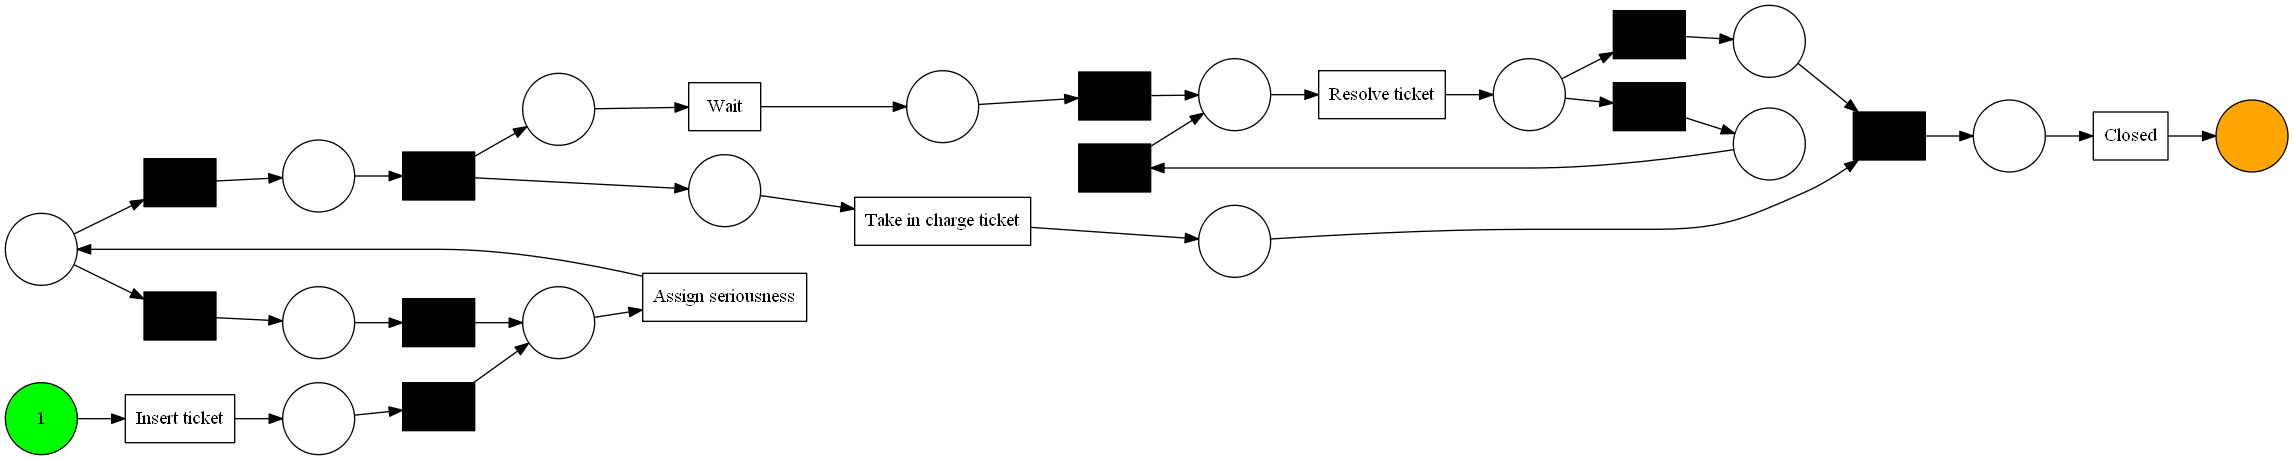

In [10]:
net, initial_marking, final_marking = inductive_miner.apply(filtered_log)
gviz_pn = pn_vis_factory.apply(net, initial_marking, final_marking)
pn_vis_factory.view(gviz_pn)

(d) Perform the token replay conformance checking using your discovered model (c) and the original event log. Does your process model fit the log?


In [11]:
token_replay = token_based_replay_factory.apply(log, net, initial_marking, final_marking)

print(log[0])
print('\n')
print(token_replay[0])

print(log[6])
print('\n')
print(token_replay[6])

{'attributes': {'concept:name': 'Case 1'}, 'events': [{'Resource': 'Value 1', 'seriousness': 'Value 1', 'seriousness_2': 'Value 1', 'service_type': 'Value 1', 'workgroup': 'Value 1', 'support_section': 'Value 1', 'customer': 'Value 1', 'service_level': 'Value 1', 'concept:name': 'Assign seriousness', 'product': 'Value 1', 'Variant2 index': 12, 'responsible_section': 'Value 1', 'time:timestamp': datetime.datetime(2012, 10, 9, 14, 50, 17, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'lifecycle:transition': 'complete', 'Variant3': 'Variant 12', 'Variant': 'Variant 12'}, '..', {'Resource': 'Value 3', 'seriousness': 'Value 1', 'seriousness_2': 'Value 1', 'service_type': 'Value 1', 'workgroup': 'Value 1', 'support_section': 'Value 1', 'customer': 'Value 1', 'service_level': 'Value 2', 'concept:name': 'Closed', 'product': 'Value 1', 'Variant2 index': 12, 'responsible_section': 'Value 1', 'time:timestamp': datetime.datetime(2012, 11, 9, 12, 54, 39, tzinfo=datetime.timezone(date

Explanation:

There will be some traces for which the model will not fit perfectly because the model is not based on all variants.
We have evaluated two random traces above, one of which has the fitness of 0.7 and another 0.8. Additional details are also provided.

(e) Calculate the fitness of the model in (c).

In [12]:
from pm4py.evaluation.replay_fitness import factory as replay_fitness_factory

fitness_tokenbasedreplay = replay_fitness_factory.apply(log, net, initial_marking, final_marking)
print(fitness_tokenbasedreplay)

{'percFitTraces': 0.1091703056768559, 'averageFitness': 0.8048500815387248}


(f) Are there any deviations between the process model and the event log? If so, where and why?

Explanation: We saw in question (h) the average fitness is less than 1. This states that there are deviations between the model and log. For example we can see token replay result of part(h) for log[6]. As we have removed the top two frequent variants this is not a preffered model.


(g) Now use the original event log and remove the two most frequent variants, and discover the model based on your new event log (the filtered log without two most frequent variants).


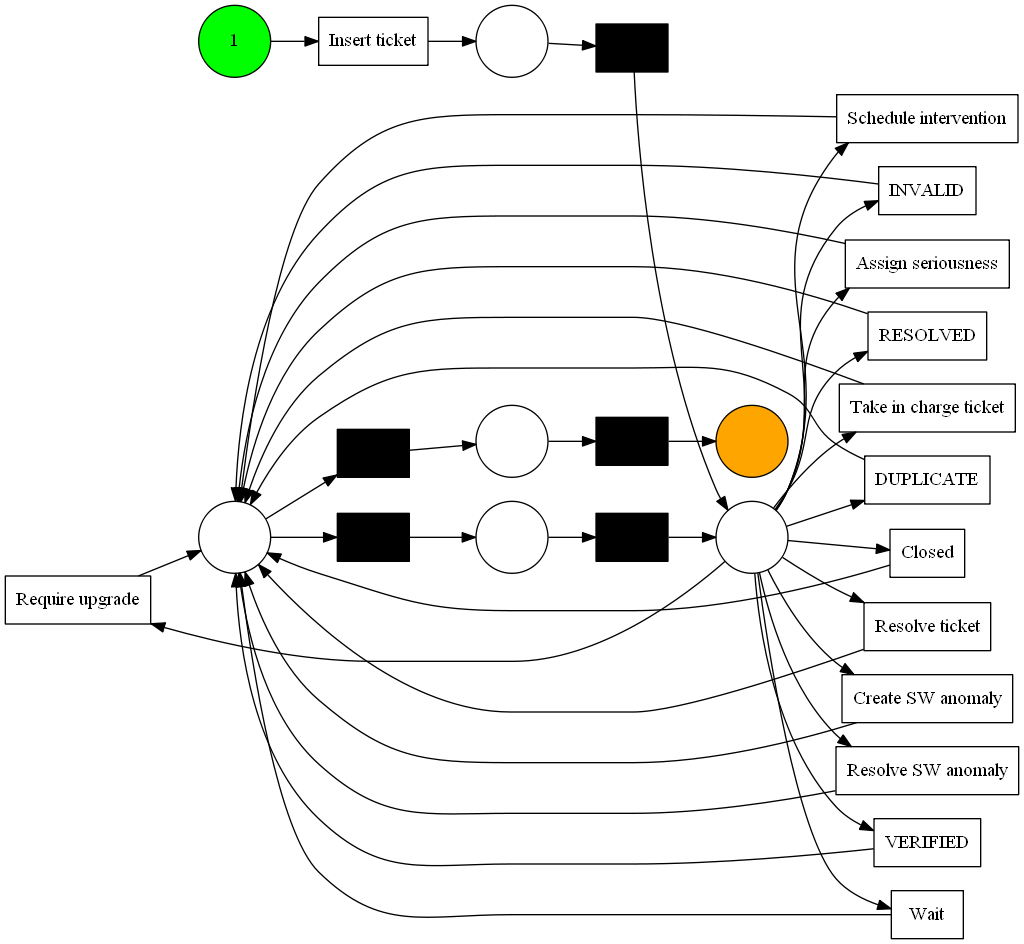

In [13]:
most_frequent_variants = []
most_frequent_variants.append(sorted_var[0]['variant'])
most_frequent_variants.append(sorted_var[1]['variant'])

filtered_log1= variants_filter.apply(log, most_frequent_variants, parameters={"positive": False})
net1, initial_marking1, final_marking1 = inductive_miner.apply(filtered_log1)
gviz_pn1 = pn_vis_factory.apply(net1, initial_marking1, final_marking1)
pn_vis_factory.view(gviz_pn1)

(h) Perform the token replay conformance checking using the newly discovered model of question (g) and the original event log. Does your process model fit the log?

In [14]:
# Your code
token_replay_result1 = token_based_replay_factory.apply(log, net1, initial_marking1, final_marking1)

print(log[0])
print('\n')
print(token_replay_result1[0])

print(log[6])
print('\n')
print(token_replay_result1[6])

{'attributes': {'concept:name': 'Case 1'}, 'events': [{'Resource': 'Value 1', 'seriousness': 'Value 1', 'seriousness_2': 'Value 1', 'service_type': 'Value 1', 'workgroup': 'Value 1', 'support_section': 'Value 1', 'customer': 'Value 1', 'service_level': 'Value 1', 'concept:name': 'Assign seriousness', 'product': 'Value 1', 'Variant2 index': 12, 'responsible_section': 'Value 1', 'time:timestamp': datetime.datetime(2012, 10, 9, 14, 50, 17, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'lifecycle:transition': 'complete', 'Variant3': 'Variant 12', 'Variant': 'Variant 12'}, '..', {'Resource': 'Value 3', 'seriousness': 'Value 1', 'seriousness_2': 'Value 1', 'service_type': 'Value 1', 'workgroup': 'Value 1', 'support_section': 'Value 1', 'customer': 'Value 1', 'service_level': 'Value 2', 'concept:name': 'Closed', 'product': 'Value 1', 'Variant2 index': 12, 'responsible_section': 'Value 1', 'time:timestamp': datetime.datetime(2012, 11, 9, 12, 54, 39, tzinfo=datetime.timezone(date

Explanation:
As we told in question (d) we have to analyze particular traces on the model to check the fitness.
Above we replayed two logs both traces fit on the model, one with fitness 0.96 and other also with 0.96,but we are not sure of this for all the traces.

(i) Calculate the fitness of the model in (g).

In [15]:
fitness_tokenbasedreplay1 = replay_fitness_factory.apply(log, net1, initial_marking1, final_marking1)
print(fitness_tokenbasedreplay1)

{'percFitTraces': 2.576419213973799, 'averageFitness': 0.849550253454069}


(j) Are there any deviations in the process model? If so, where and why?

Explaination:
As we can see in (h) the average fitness is less than 1. This shows that there are discrepencies between the model and log. For instance, we can see token replay result of part(h) for log[6] .
Also there are few remaining tokens in the model and no token reached the final marking. The reason behind this deviations is probably because not all the traces are not used to create the model, which leads to the possibility of some traces not fitting the model.

(k) Use the complete event log (original event log) and discover your process model using Inductive Miner.


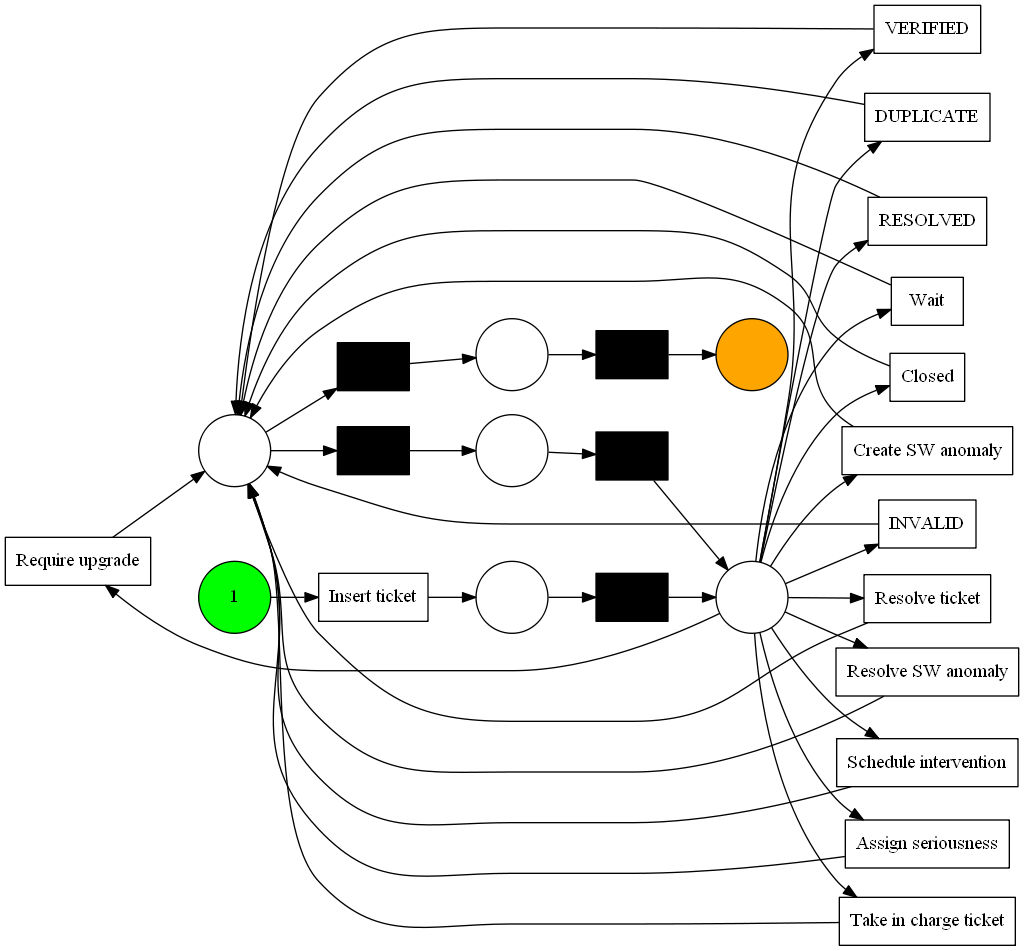

In [16]:
net2, initial_marking2, final_marking2 = inductive_miner.apply(log)
gviz_pn2 = pn_vis_factory.apply(net2, initial_marking2, final_marking2)
pn_vis_factory.view(gviz_pn2)

(l) Do the token replay conformance checking using your newly discovered model and the original event log. Does your process model fit the log?

In [18]:
# Your code
token_replay_result2 = token_based_replay_factory.apply(log, net2, initial_marking2, final_marking2)

print(log[0])
print('\n')
print(token_replay_result2[0])

print(log[6])
print('\n')
print(token_replay_result2[6])

{'attributes': {'concept:name': 'Case 1'}, 'events': [{'Resource': 'Value 1', 'seriousness': 'Value 1', 'seriousness_2': 'Value 1', 'service_type': 'Value 1', 'workgroup': 'Value 1', 'support_section': 'Value 1', 'customer': 'Value 1', 'service_level': 'Value 1', 'concept:name': 'Assign seriousness', 'product': 'Value 1', 'Variant2 index': 12, 'responsible_section': 'Value 1', 'time:timestamp': datetime.datetime(2012, 10, 9, 14, 50, 17, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'lifecycle:transition': 'complete', 'Variant3': 'Variant 12', 'Variant': 'Variant 12'}, '..', {'Resource': 'Value 3', 'seriousness': 'Value 1', 'seriousness_2': 'Value 1', 'service_type': 'Value 1', 'workgroup': 'Value 1', 'support_section': 'Value 1', 'customer': 'Value 1', 'service_level': 'Value 2', 'concept:name': 'Closed', 'product': 'Value 1', 'Variant2 index': 12, 'responsible_section': 'Value 1', 'time:timestamp': datetime.datetime(2012, 11, 9, 12, 54, 39, tzinfo=datetime.timezone(date

Explanation:  All the traces fit the model because the model was generated with all the traces.

(m) How are these three discovered process models different from each other? Which model is the best fitting to the original log? Why?

Explaination: First model: This model is simple to understand. We used most frequent variants, this model is better because it represents the actual model which makes it more realistic. 
Second model: It is not a preferred model. We have removed the top two frequent variants.

Final model: Used all variants i.e. traces. 

The final model is a better model because we have used all the traces. We have also used the less frequent variants.

(n) Visualize the model discovered in question (k) enriched with frequency information. Subsequently, visualize that same model enriched with performance information.

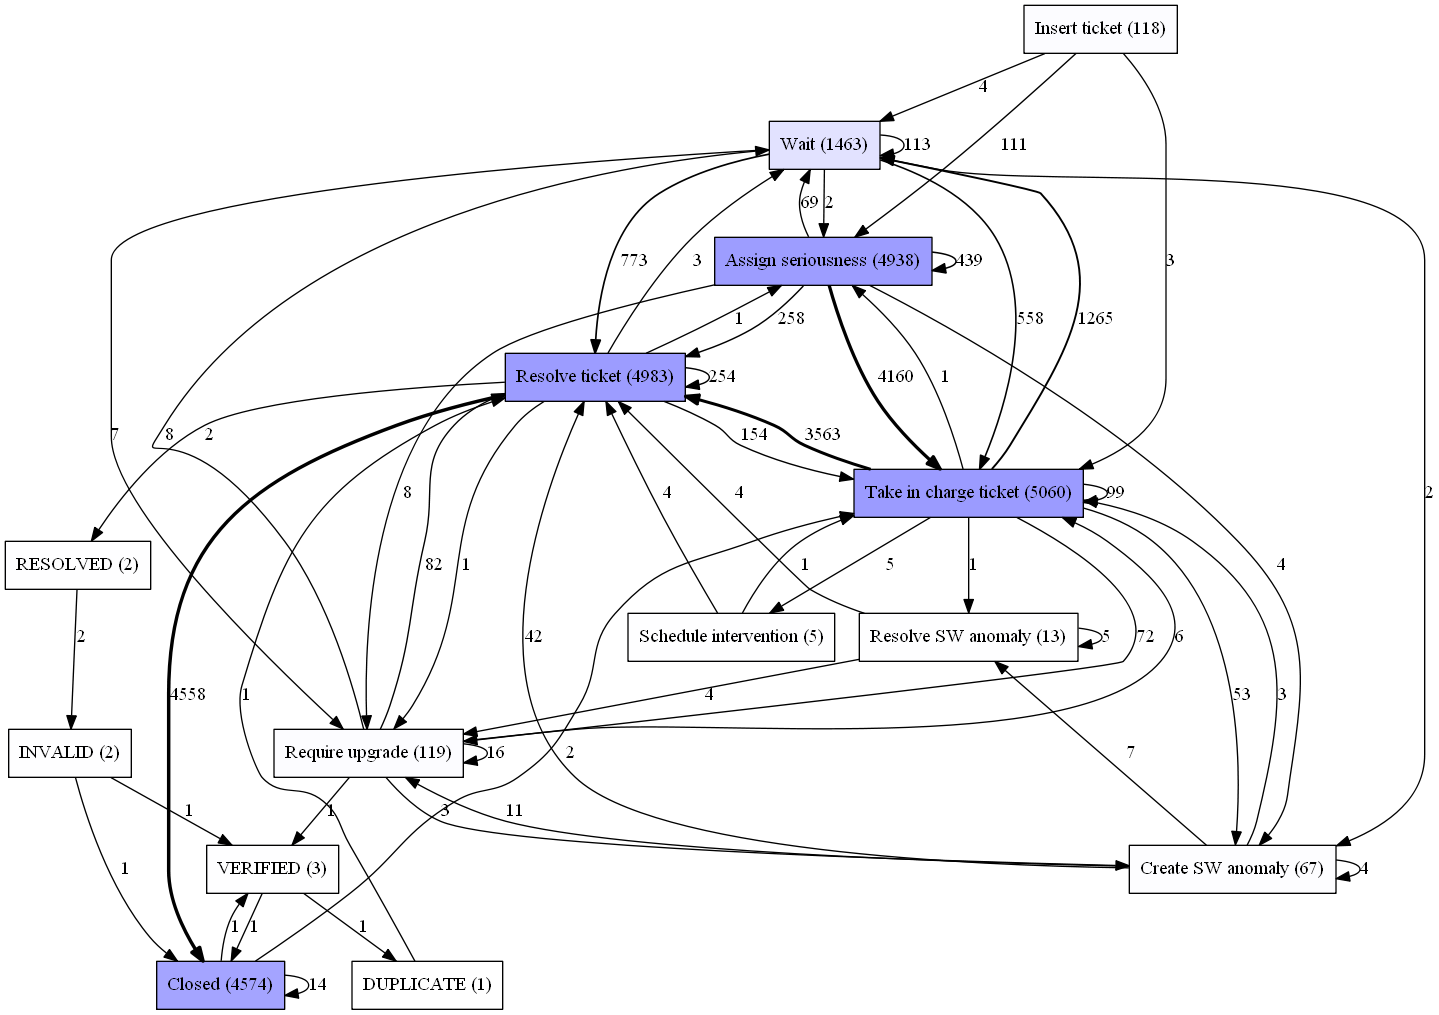

In [19]:
# Your code
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.visualization.dfg import factory as dfg_vis_factory

dfg = dfg_factory.apply(log)

gviz_dfg = dfg_vis_factory.apply(dfg, log=log, variant='frequency')
dfg_vis_factory.view(gviz_dfg)

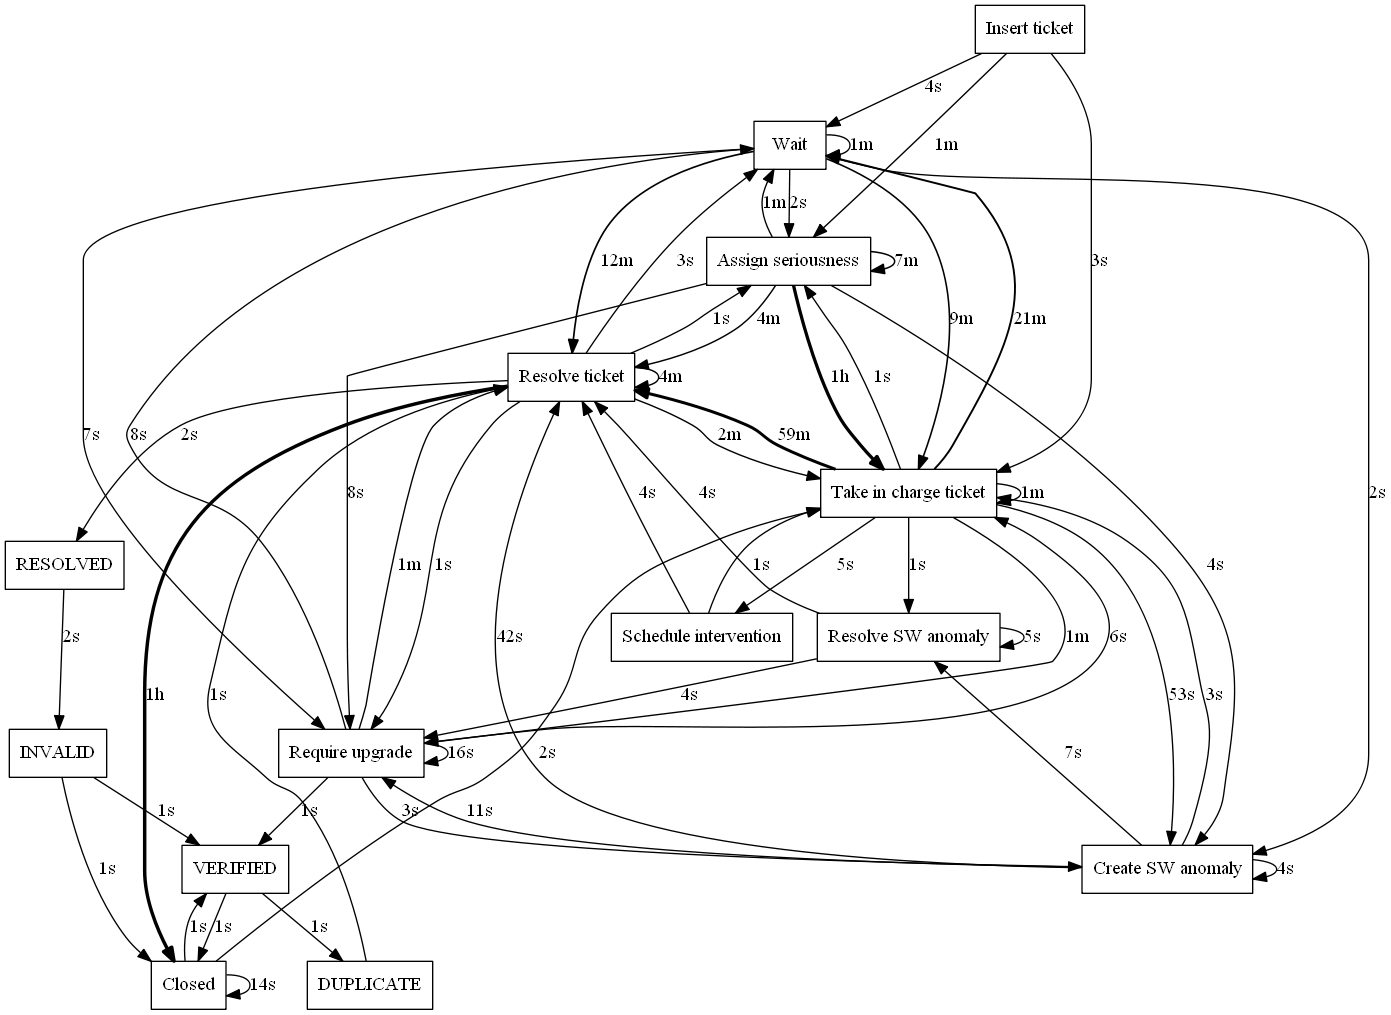

In [20]:
gviz_dfg = dfg_vis_factory.apply(dfg, log=log, variant='performance')
dfg_vis_factory.view(gviz_dfg)

(o) If you were the process owner and you had more resources to hire employees, on which parts of the process would you assign them to maximize efficiency?

Explaination: From the frequency DFG, we can see that the most frequent activities are 'Take in charge ticket(5060)', 'Resolve ticket(4983)','Assign Seriousness(4938)','Closed(4574)' in the same order.
From the performance DFG we can see that "Closed" activity doesn't take that much time to perform. The other 3 activities all take around 1 hour to finish. To make the whole process more efficient we would employ more persons to handle the 3 activities which takes around 1 hour to finish.

(p) Add your further comments and considerations on the frequency and performance informations. Does the process have a "happy path", and is it shown in the enhanced process models? Where are the major bottlenecks in this process? Is there any rework?

Explanation: Yes, the model has a "happy path" ['Assign seriousness,Take in charge ticket,Resolve ticket,Closed', 'count': 2366].


Major bottlenecks: As we discussed earlier the main activities like "Take in charge ticket(5060)", "Resolve Ticket(4983)", "Assign Seriousness(4938)" consumes a large amount of time. If these can be handled efficiently the whole process can be finished faster.

Rework: Yes in many activities there are self-loops like "Assign Seriousness(439)", "Resolve Ticket(254)", "wait(113)", "Take in charge ticket(99)" etc. The frequency is given in the brackets, how many time the same activity is followed by itself.